# Nanopore long-read sequencing uncovers hundreds of structural variants in the Schistosome genome
*Shalini Nair, Elisha Enabulele, Xue Li, Tim Anderson, Neal Platt*

__ABSTRACT__: Nanopore sequencing generates extremely long sequence reads allowing detailed characterization of genomic features (genome rearrangements/structural variants) that are difficult to accurately assay using Illumina short-read sequencing approaches. Technological improvements in Nanopore long-read sequence have resulted in reduced prices, as well as increased accuracy and output. This method was declared “Method of the year” in Nature in 2022. Our laboratory is exploring the use of nanopore for characterizing pathogen genomes. Here, we detail application of nanopore sequencing of schistosome parasites. These parasites have a 380 Mb genome that is riddled with repetitive elements and structural variants. We have developed protocols that allow generation of reads up to 200kb, with 50% of reads > 24kb, and generation of 13.5 Gb of high-quality data from a single R10 flow cell, providing 27x coverage of the parasite genome.  Using this new data, we have identified multiple structural variants segregating in a lab strain of S. mansoni that would not have been visible using short read sequencing alone.  For example, we have found 468 large structural variants (>500bp) that were completely fixed in our laboratory population compared to the reference genome/strain. We anticipate that characterization of large structural variants may help to identify causative features underlying important schistosome phenotypes. Nanopore also has many possible uses for other researchers at Texas biomed, including sequencing entire viral genomes or host MHC, and rapid monitoring of infectious diseases in global populations.

**[08/04/2023] Nanopore analysis ideas**

- Are the genomes of lab populations syntenic or have large changes in gene structure/order been introduced?
  - __This would be extremely interesting__
  - Aside – one possible explanation for the division between Sh populations might be rearrangements/inversions
- What impact do large SVs have on the coding regions of the genome?
  - Comment – define impact here. It would certainly be interesting to know whether SVs in coding sequences seem likely to reduce/eliminate gene expression
- Is there evidence of population specific SVs (including CNVs/gene family expansions/contractions)?
- Can we recover and examine variability in complex regions like SmPoMucs and how is this variability distributed among and within lab populations?
  - __Yes – v important.__
  - Simply identifying the genome location of these genes will be very important – we would like to be able to definitively state that smPoMucs do/do not colocalize with the host specificity QTLs that Fred has mapped.
- Are there large SVs in important regions associated with parasite phenotypes?
  - Important question but difficult to do. I think we can certainly examine how many SVs are segregating in QTL regions, to highlight possible causative SVs
- (Some interesting question about the tandem repeat region in the mitochondrial genome...not sure what yet)
  - There is some old literature about these regions, suggesting v rapid change and extensive polymorphism within individuals. This might be difficult with the population data, but would be great to do when we have data from individual genotypes. Perhaps worth waiting until we have that data.
- __Is it possible to identify SVs that are being selected (for/against)?__
  - I think this is particularly interesting. We expect most SVs to be selected against.
  - Comparing allele frequencies within populations would be informative – we expect most to be at low frequency. High frequency SVs are good candidates for positive selection
  - __Comparing SV burden in coding vs non-coding regions would be informative to understand strength of selection against SVs__
  - __Likewise, comparing SVs in low and high recombination rate regions. We predict higher frequency/larger SVs in high recombination regions__

# Preping for structural variants

## Prep analyses

In [67]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
# from Bio import SeqIO
# from Bio.SeqRecord import SeqRecord
import vcf
from itertools import combinations
import venn
import io
import gffutils
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm


In [3]:
proj_dir = "/master/nplatt/sch_man_ont"
ref_fas = "{}/data/genome/SM_V10.fa".format(proj_dir)
Path("{}/results".format(proj_dir)).mkdir(parents=True, exist_ok=True)

In [4]:
samples = [ "smbre",
            "smeg", 
            "smle-pzq-er",
            "smle-pzq-es",
            "smor" ]

pops=samples

In [5]:
os.chdir("{}/results".format(proj_dir))

## Raw Long Reads

In [5]:
Path("{}/results/raw_reads".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/raw_reads".format(proj_dir))

In [ ]:
# DATA=/master/nplatt/sch_man_ont/data

# zcat $DATA/schisto_pairs_04132022/no_sample/20220413_1030_MC-110254_FAS57617_fdc4f280/fastq_pass/FAS57617_pass_f77dcaa6_*gz \
#     $DATA/V14_Smle_S/no_sample/20230109_1649_MC-110254_FAV67293_20684beb/fastq_pass/FAV67293_pass_20684beb_b8e64529_*gz \
#     $DATA/V14_Smle_S_2/no_sample/20230110_1931_MC-110254_FAV67293_70d56838/fastq_pass/FAV67293_pass_70d56838_f285c3d6_*gz \
#     >smle-pzq-es.fastq &

# zcat $DATA/V14_Smle_R/no_sample/20230105_1829_MC-110254_FAU92303_cc3e8354/fastq_pass/FAU92303_pass_cc3e8354_368dd688_*gz \
#     >smle-pzq-er.fastq &

# zcat $DATA/SmEG_2/no_sample/20221219_1251_MC-110254_FAV14922_3a8a2fa9/fastq_pass/FAV14922_pass_24ea1607_*gz >smeg2.fastq &

# zcat $DATA/SmEG_Female_6_02_22/no_sample/20220523_1102_MC-110254_FAT13494_c562973b/fastq_pass/FAT13494_pass_5a70f0ff_*.gz >06_02_22.fastq &

# zcat $DATA/SmOR_Female_5_25_22/no_sample/20220530_1011_MC-110254_FAT30731_19d6f87b/fastq_pass/FAT30731_pass_99b43000_*.gz >05_25_22.fastq &

In [ ]:
%%bash 

DATA=/master/nplatt/sch_man_ont/data

# smbre ----------------------
zcat $DATA/SmBRE_10182022/no_sample/20221018_1043_MC-110254_FAT94061_3be94c01/fastq_pass/FAT94061_pass_5e6aef65_*gz >smbre.fastq &
# ----------------------------

# smeg -----------------------
zcat $DATA/SmEG_2/no_sample/20221219_1251_MC-110254_FAV14922_3a8a2fa9/fastq_pass/FAV14922_pass_24ea1607_*gz \
     $DATA/SmEG_Female_6_02_22/no_sample/20220523_1102_MC-110254_FAT13494_c562973b/fastq_pass/FAT13494_pass_5a70f0ff_*.gz\
     >smeg.fastq &
#-----------------------------

# smle-pzq-er ----------------
zcat $DATA/V14_Smle_R/no_sample/20230105_1829_MC-110254_FAU92303_cc3e8354/fastq_pass/FAU92303_pass_cc3e8354_368dd688_*gz \
    >smle-pzq-er.fastq &
#-----------------------------

# smle-pzq-es ----------------
zcat $DATA/schisto_pairs_04132022/no_sample/20220413_1030_MC-110254_FAS57617_fdc4f280/fastq_pass/FAS57617_pass_f77dcaa6_*gz \
    $DATA/V14_Smle_S/no_sample/20230109_1649_MC-110254_FAV67293_20684beb/fastq_pass/FAV67293_pass_20684beb_b8e64529_*gz \
    $DATA/V14_Smle_S_2/no_sample/20230110_1931_MC-110254_FAV67293_70d56838/fastq_pass/FAV67293_pass_70d56838_f285c3d6_*gz \
    >smle-pzq-es.fastq &
#----------------------------

# smor ----------------------
zcat $DATA/SmOR_Female_5_25_22/no_sample/20220530_1011_MC-110254_FAT30731_19d6f87b/fastq_pass/FAT30731_pass_99b43000_*.gz >smor.fastq &
#----------------------------


# Run snakemake

In [ ]:
#snakemake --printshellcmds --cluster 'qsub -V -cwd -j y -S /bin/bash -pe smp {threads} -q all.q -o {log} ' --jobs 200 --latency-wait 200 --keep-going --rerun-incomplete --snake code/sch_man_ont.snk.py --use-conda --jobname snk.NGR.{name}.jid{jobid}

# Filter and process SVS that impact exons:

In [65]:
Path("{}/results/process_svs_in_genes".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/process_svs_in_genes".format(proj_dir))

In [66]:
%%bash 

grep -i exon /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >smv10_exons.gtf

for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do
    #convert SVs vcfs to bed
    
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%END\t%ID\n" ../debreak/${POP}.debreak.vcf >${POP}.debreak.bed
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%END\t%ID\n" ../cutesv/${POP}.cutesv.vcf >${POP}.cutesv.bed
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%END\t%ID\n" ../sniffles/${POP}.sniffles.vcf >${POP}.sniffles.bed


    conda run -n bedtools --cwd . --live-stream bedtools intersect -a ${POP}.debreak.bed -b smv10_exons.gtf -u >${POP}.debreak.svs_in_exons.bed
    conda run -n bedtools --cwd . --live-stream bedtools intersect -a ${POP}.cutesv.bed -b smv10_exons.gtf -u >${POP}.cutesv.svs_in_exons.bed
    conda run -n bedtools --cwd . --live-stream bedtools intersect -a ${POP}.sniffles.bed -b smv10_exons.gtf -u >${POP}.sniffles.svs_in_exons.bed

    conda run -n vcftools --cwd . --live-stream
done

In [72]:
variant_ids = list(pd.read_csv(f"{pop}.{caller}.svs_in_exons.bed", sep="\t", header=None)[3])

In [137]:
from collections import defaultdict

with open("svs.exons.af_gt_95.bed", 'w') as bed:

    for pop in pops:
        vids = []
    
        for caller in ["cutesv"]:
            print(f"{pop}.{caller}")
            variant_ids = list(pd.read_csv(f"{pop}.{caller}.svs_in_exons.bed", sep="\t", header=None)[3])
    
            in_vcf = f"{proj_dir}/results/{caller}/{pop}.{caller}.vcf"
            vcf_reader = vcf.Reader(filename=in_vcf)
            
            out_vcf = f"{pop}.{caller}.exons.af_gt_95.vcf"
            vcf_writer = vcf.Writer(open(out_vcf, 'w'), vcf_reader)  # Replace 'output_file.vcf' with your desired output file path
    
            for record in vcf_reader:
                if (record.INFO["AF"][0] is not None):
                    if ( (record.ID in variant_ids) & (float(record.INFO["AF"][0]) > 0.95) ):
                        vcf_writer.write_record(record)
    
                        
                        chr = record.CHROM
                        pos = record.POS
                        end = record.INFO["END"]
                        svtype = record.INFO["SVTYPE"]
                        vid = f"{chr}:{pos}:{end}:{svtype}"
    
                        # bed.append(f"{chr}\t{pos}\t{end}\t{vid}\t{pop}\t{caller}")
                
                        bed.write(f"{chr}\t{pos}\t{end}\t{vid}\t{pop}\t{caller}\n")
            
            # Close the VCF writer
            vcf_writer.close()

smbre.cutesv
smeg.cutesv
smle-pzq-er.cutesv
smle-pzq-es.cutesv
smor.cutesv


In [139]:
bed_df=pd.read_csv("svs.exons.af_gt_95.bed", sep="\t", header=None)
bed_df

,0,1,2,3,4,5
0,SM_V10_1,918029,1058809,SM_V10_1:918029:1058809:INV,smbre,cutesv
1,SM_V10_1,1024111,1059194,SM_V10_1:1024111:1059194:DEL,smbre,cutesv
2,SM_V10_1,2357781,2357781,SM_V10_1:2357781:2357781:INS,smbre,cutesv
3,SM_V10_1,4305258,4305258,SM_V10_1:4305258:4305258:INS,smbre,cutesv
4,SM_V10_1,4708530,4711653,SM_V10_1:4708530:4711653:DEL,smbre,cutesv
...,...,...,...,...,...,...
1022,SM_V10_Z,81621334,81621360,SM_V10_Z:81621334:81621360:DEL,smor,cutesv
1023,SM_V10_Z,82253225,82256393,SM_V10_Z:82253225:82256393:DEL,smor,cutesv
1024,SM_V10_Z,84350364,84350364,SM_V10_Z:84350364:84350364:INS,smor,cutesv
1025,SM_V10_Z,86176606,86176606,SM_V10_Z:86176606:86176606:INS,smor,cutesv


In [ ]:
#use bedtools to filtr

In [ ]:
bedtools slop -i svs.exons.af_gt_95.bed -g ../../data/genome/SM_V10.fa.fai  -b 501 | bedtools sort >slopped.bed

In [ ]:
bedtools merge -d 1 -i slopped.bed >merged.bed

In [ ]:
bedtools closest -d -io -a merged.bed -b merged.bed | awk '{if ($7 > 1000) print $0}' >sep.bed

In [141]:
%%bash 

for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do

    conda run -n vcftools --cwd . --live-stream vcftools --vcf ${POP}.cutesv.exons.af_gt_95.vcf --bed sep.bed --recode --recode-INFO-all --out ${POP}
done


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf smeg.cutesv.exons.af_gt_95.vcf
	--recode-INFO-all
	--out smeg
	--recode
	--bed sep.bed

After filtering, kept 1 out of 1 Individuals
Outputting VCF file...
	Read 473 BED file entries.
After filtering, kept 79 out of a possible 104 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf smbre.cutesv.exons.af_gt_95.vcf
	--recode-INFO-all
	--out smbre
	--recode
	--bed sep.bed

After filtering, kept 1 out of 1 Individuals
Outputting VCF file...
	Read 473 BED file entries.
After filtering, kept 229 out of a possible 302 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf smor.cutesv.exons.af_gt_95.vcf
	--recode-INFO-all
	--out smor
	--recode
	--bed sep.bed

After filtering, kept 1 out of 1 Individuals
Outputting VCF file...
	Read 473 BED file entries.
Aft

In [142]:
!ls *recode.vcf >vcfs.list

!SURVIVOR merge vcfs.list 100 1 1 0 0 50 merged.vcf


In [ ]:
for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do
    svjedi-graph.py \
        --vcf merged.vcf \
        --ref ../../data/genome/SM_V10.fa \
        --reads ../nanoq/${POP}.nanoq.fastq \
        --prefix ${POP} \
        --threads 48 \
        --minsupport 5 
done


In [143]:
%%bash


for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do
    echo -e "chr\tpos\tid\tref\talt\tqual\tfilter\tsvlen\tsvtype\tchr2\tend\tcipos\tgt.${POP}\tdp.${POP}\tad.${POP}\tpl.${POP}" > ${POP}.svjedi.tsv
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%ID\t%REF\t%ALT\t%QUAL\t%FILTER\t%SVLEN\t%SVTYPE\t%CHR2\t%END\t%CIPOS\t[%GT\t%DP\t%AD\t%PL]\n" ${POP}_genotype.vcf >> ${POP}.svjedi.tsv
done

[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::bcf_hdr_check_sanity] PL should be declared as Number=G


In [145]:
%%bash 

cat smbre.svjedi.tsv >smbre.tmp

for POP in smeg smle-pzq-er smle-pzq-es smor; do

        cut -f13-16 ${POP}.svjedi.tsv >${POP}.tmp
        cut -f13-16 ${POP}.svjedi.tsv >${POP}.tmp
        cut -f13-16 ${POP}.svjedi.tsv >${POP}.tmp
        cut -f13-16 ${POP}.svjedi.tsv >${POP}.tmp
done

paste smbre.tmp smeg.tmp smle-pzq-er.tmp smle-pzq-es.tmp smor.tmp >merged.exons.jedi.tsv

rm *.tmp


In [146]:
df=pd.read_csv("merged.exons.jedi.tsv", header=0, sep="\t")
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,"1,16","675,38,30",1/1,42.0,"0,42","1806,126,0",1/1,35.0,"0,35","1505,105,0"
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,"3.5,15","609,19,114",0/1,31.5,"4.5,27","1116,49,148",1/1,23.0,"0,23","989,69,0"
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,"2,9","369,15,68",0/1,49.0,"18,31","1202,16,643",1/1,23.0,"0,23","989,69,0"
3,SM_V10_1,8441298,cuteSV.DEL.706,ATTTTATAATTACAAGTTAACCTATTGAATAGATATACATGTATAA...,A,439,PASS,-54,DEL,SM_V10_1,...,"0,5","215,15,0",1/1,42.0,"0,42","1806,126,0",1/1,29.0,"0,29","1247,87,0"
4,SM_V10_1,8452810,cuteSV.INS.361,G,GTTAATGTTTTATTATTATTTATTTATTTAAACACATATATATTGG...,248,PASS,506,INS,SM_V10_1,...,"1,1","40,3,40",0/1,40.0,"21,19","706,9,792",1/1,28.0,"0,28","1204,84,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,"3,9","363,12,105",0/1,50.5,"9,41.5","1690,57,292",0/1,19.0,"2,17","708,34,63"
217,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,"6.5,5","188,7,252",0/1,59.0,"14,45","1804,46,470",1/1,32.0,"0,32","1376,96,0"
218,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,"2,9","369,15,68",1/1,46.0,"2,44","1862,108,55",0/1,34.0,"19,15","552,9,724"
219,SM_V10_Z,86176606,cuteSV.INS.9324,A,AATTGATCTCATCATTCACGCAACCATCAGCACTTATCTAGCTACC...,314,PASS,749,INS,SM_V10_Z,...,"0,14.5","623,43,0",1/1,40.0,"1,39","1661,104,26",1/1,24.0,"0,24","1032,72,0"


In [147]:
df = df.loc[df["filter"] == "PASS"]
df=df.reset_index(drop=True)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,"1,16","675,38,30",1/1,42.0,"0,42","1806,126,0",1/1,35.0,"0,35","1505,105,0"
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,"3.5,15","609,19,114",0/1,31.5,"4.5,27","1116,49,148",1/1,23.0,"0,23","989,69,0"
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,"2,9","369,15,68",0/1,49.0,"18,31","1202,16,643",1/1,23.0,"0,23","989,69,0"
3,SM_V10_1,8441298,cuteSV.DEL.706,ATTTTATAATTACAAGTTAACCTATTGAATAGATATACATGTATAA...,A,439,PASS,-54,DEL,SM_V10_1,...,"0,5","215,15,0",1/1,42.0,"0,42","1806,126,0",1/1,29.0,"0,29","1247,87,0"
4,SM_V10_1,8452810,cuteSV.INS.361,G,GTTAATGTTTTATTATTATTTATTTATTTAAACACATATATATTGG...,248,PASS,506,INS,SM_V10_1,...,"1,1","40,3,40",0/1,40.0,"21,19","706,9,792",1/1,28.0,"0,28","1204,84,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,"3,9","363,12,105",0/1,50.5,"9,41.5","1690,57,292",0/1,19.0,"2,17","708,34,63"
217,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,"6.5,5","188,7,252",0/1,59.0,"14,45","1804,46,470",1/1,32.0,"0,32","1376,96,0"
218,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,"2,9","369,15,68",1/1,46.0,"2,44","1862,108,55",0/1,34.0,"19,15","552,9,724"
219,SM_V10_Z,86176606,cuteSV.INS.9324,A,AATTGATCTCATCATTCACGCAACCATCAGCACTTATCTAGCTACC...,314,PASS,749,INS,SM_V10_Z,...,"0,14.5","623,43,0",1/1,40.0,"1,39","1661,104,26",1/1,24.0,"0,24","1032,72,0"


In [148]:
df["svtype"].value_counts()

svtype
DEL    141
INS     79
INV      1
Name: count, dtype: int64

In [149]:
dp_cols = [f"dp.{pop}" for pop in pops]

depth_filter = (df[dp_cols] > 10) & (df[dp_cols] < 80)

depth_filter_idx = df[depth_filter.sum(axis=1) == 5].index

df = df.iloc[depth_filter_idx].reset_index(drop=True)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,"1,16","675,38,30",1/1,42.0,"0,42","1806,126,0",1/1,35.0,"0,35","1505,105,0"
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,"3.5,15","609,19,114",0/1,31.5,"4.5,27","1116,49,148",1/1,23.0,"0,23","989,69,0"
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,"2,9","369,15,68",0/1,49.0,"18,31","1202,16,643",1/1,23.0,"0,23","989,69,0"
3,SM_V10_1,9896184,cuteSV.INS.516,A,ATTAATCTACCTATTCGGCTATTCGTCGATATTTAGGGGAAAAGTC...,209,PASS,257,INS,SM_V10_1,...,"15,0","0,45,645",0/0,43.0,"43,0","0,129,1849",0/1,25.5,"17,8.5","305,16,670"
4,SM_V10_1,10117458,cuteSV.DEL.598,ACATTGTTATAATTCTACACTCCTGTATGACTACGTATGACTCATG...,A,190,PASS,-1228,DEL,SM_V10_1,...,"16,0","0,48,688",0/0,38.5,"38.5,0","0,115,1655",1/1,24.0,"0,24","1032,72,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,SM_V10_Z,81360724,cuteSV.INS.16376,A,AACCTGTTTTTTTACTTTAAATATAATCAATTATTTGGTTATGATA...,181,PASS,4458,INS,SM_V10_Z,...,"3,14","573,22,100",0/1,55.0,"8,47","1930,74,253",0/1,35.0,"3,32","1338,67,90"
168,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,"3,9","363,12,105",0/1,50.5,"9,41.5","1690,57,292",0/1,19.0,"2,17","708,34,63"
169,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,"6.5,5","188,7,252",0/1,59.0,"14,45","1804,46,470",1/1,32.0,"0,32","1376,96,0"
170,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,"2,9","369,15,68",1/1,46.0,"2,44","1862,108,55",0/1,34.0,"19,15","552,9,724"


In [150]:
df["svtype"].value_counts()

svtype
DEL    107
INS     64
INV      1
Name: count, dtype: int64

In [151]:
ad_cols = [f"ad.{pop}" for pop in pops]

for pop in pops:
    alt_ad_s = [float(ad.split(",")[1]) for ad in df[f"ad.{pop}"]]
    dp_s = df[f"dp.{pop}"].astype(float)
    af_s = alt_ad_s/dp_s
    df[f"af.{pop}"]=af_s

df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,"1806,126,0",1/1,35.0,"0,35","1505,105,0",1.000000,1.000000,0.941176,1.000000,1.000000
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,"1116,49,148",1/1,23.0,"0,23","989,69,0",0.865979,0.434783,0.810811,0.857143,1.000000
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,"1202,16,643",1/1,23.0,"0,23","989,69,0",0.949153,0.896552,0.818182,0.632653,1.000000
3,SM_V10_1,9896184,cuteSV.INS.516,A,ATTAATCTACCTATTCGGCTATTCGTCGATATTTAGGGGAAAAGTC...,209,PASS,257,INS,SM_V10_1,...,"0,129,1849",0/1,25.5,"17,8.5","305,16,670",0.666667,0.235294,0.000000,0.000000,0.333333
4,SM_V10_1,10117458,cuteSV.DEL.598,ACATTGTTATAATTCTACACTCCTGTATGACTACGTATGACTCATG...,A,190,PASS,-1228,DEL,SM_V10_1,...,"0,115,1655",1/1,24.0,"0,24","1032,72,0",0.536585,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,SM_V10_Z,81360724,cuteSV.INS.16376,A,AACCTGTTTTTTTACTTTAAATATAATCAATTATTTGGTTATGATA...,181,PASS,4458,INS,SM_V10_Z,...,"1930,74,253",0/1,35.0,"3,32","1338,67,90",0.943925,1.000000,0.823529,0.854545,0.914286
168,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,"1690,57,292",0/1,19.0,"2,17","708,34,63",0.798561,0.666667,0.750000,0.821782,0.894737
169,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,"1804,46,470",1/1,32.0,"0,32","1376,96,0",0.849057,0.529412,0.434783,0.762712,1.000000
170,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,"1862,108,55",0/1,34.0,"19,15","552,9,724",0.898305,0.911765,0.818182,0.956522,0.441176


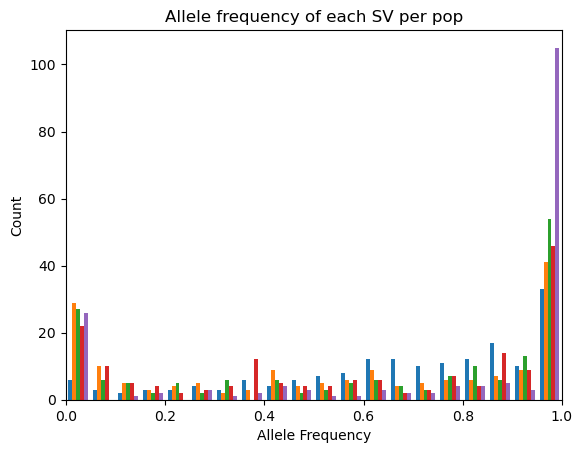

In [152]:
af_cols = [f"af.{pop}" for pop in pops]

plt.hist(df[af_cols], bins=20)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Allele frequency of each SV per pop")
# plt.legend()
plt.xlim([0, 1])
plt.show()

In [153]:
#shared SVs are present at >50% in 4 of 5 populations
af_cols = [f"af.{pop}" for pop in pops]


shared_conditions = (df[af_cols] > 0.5)
fixed_conditions = (df[af_cols]  > 0.95)

shared_idx = df[shared_conditions.sum(axis=1) == 5].index
fixed_idx  = df[fixed_conditions.sum(axis=1) >= 1].index

idxs=list(set(list(shared_idx) + list(fixed_idx)))
idxs.sort()

df = df.iloc[idxs].reset_index(drop=True)

df = df[~df[af_cols].isin(['.']).any(axis=1)].reset_index(drop=True)

df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,"1806,126,0",1/1,35.0,"0,35","1505,105,0",1.000000,1.000000,0.941176,1.000000,1.000000
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,"1116,49,148",1/1,23.0,"0,23","989,69,0",0.865979,0.434783,0.810811,0.857143,1.000000
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,"1202,16,643",1/1,23.0,"0,23","989,69,0",0.949153,0.896552,0.818182,0.632653,1.000000
3,SM_V10_1,10117458,cuteSV.DEL.598,ACATTGTTATAATTCTACACTCCTGTATGACTACGTATGACTCATG...,A,190,PASS,-1228,DEL,SM_V10_1,...,"0,115,1655",1/1,24.0,"0,24","1032,72,0",0.536585,0.000000,0.000000,0.000000,1.000000
4,SM_V10_1,13400167,cuteSV.DEL.383,AGATTTTAAAGCAATTAGTCCCTTTTATAAATTTCGATAGAACAAT...,A,572,PASS,-11567,DEL,SM_V10_1,...,"2666,186,0",0/1,21.0,"13,8","290,10,506",1.000000,1.000000,1.000000,1.000000,0.380952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,SM_V10_Z,81360724,cuteSV.INS.16376,A,AACCTGTTTTTTTACTTTAAATATAATCAATTATTTGGTTATGATA...,181,PASS,4458,INS,SM_V10_Z,...,"1930,74,253",0/1,35.0,"3,32","1338,67,90",0.943925,1.000000,0.823529,0.854545,0.914286
133,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,"1690,57,292",0/1,19.0,"2,17","708,34,63",0.798561,0.666667,0.750000,0.821782,0.894737
134,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,"1804,46,470",1/1,32.0,"0,32","1376,96,0",0.849057,0.529412,0.434783,0.762712,1.000000
135,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,"1862,108,55",0/1,34.0,"19,15","552,9,724",0.898305,0.911765,0.818182,0.956522,0.441176


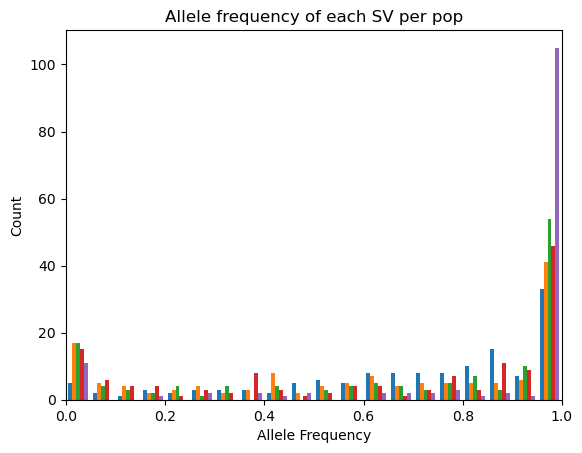

In [154]:
af_cols = [f"af.{pop}" for pop in pops]

plt.hist(df[af_cols], bins=20)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Allele frequency of each SV per pop")
# plt.legend()
plt.xlim([0, 1])
plt.show()

In [155]:
af_diffs=[]
af_cols = [f"af.{pop}" for pop in pops]


for index, row in df[af_cols].iterrows():
    afs=list(row[af_cols])
    afs.sort()
    af_diffs.append(afs[-1] - afs[-2])


df["delta_af"] = af_diffs

df.to_csv("processed_svs.exons.tsv", sep="\t", header=True, index=False)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
0,SM_V10_1,4305258,cuteSV.INS.134,A,ATTGGAGTGTCTATTGCTTGTATGGTAGATCAGTTGATTAATTCAG...,391,PASS,200,INS,SM_V10_1,...,1/1,35.0,"0,35","1505,105,0",1.000000,1.000000,0.941176,1.000000,1.000000,0.000000
1,SM_V10_1,4708531,cuteSV.DEL.283,AAGTTTCAGTTTCAGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGC...,A,305,PASS,-3123,DEL,SM_V10_1,...,1/1,23.0,"0,23","989,69,0",0.865979,0.434783,0.810811,0.857143,1.000000,0.134021
2,SM_V10_1,8040390,cuteSV.DEL.446,ATATATATATATATATATATATATATATATATATATATATATATAT...,A,286,PASS,-64,DEL,SM_V10_1,...,1/1,23.0,"0,23","989,69,0",0.949153,0.896552,0.818182,0.632653,1.000000,0.050847
3,SM_V10_1,10117458,cuteSV.DEL.598,ACATTGTTATAATTCTACACTCCTGTATGACTACGTATGACTCATG...,A,190,PASS,-1228,DEL,SM_V10_1,...,1/1,24.0,"0,24","1032,72,0",0.536585,0.000000,0.000000,0.000000,1.000000,0.463415
4,SM_V10_1,13400167,cuteSV.DEL.383,AGATTTTAAAGCAATTAGTCCCTTTTATAAATTTCGATAGAACAAT...,A,572,PASS,-11567,DEL,SM_V10_1,...,0/1,21.0,"13,8","290,10,506",1.000000,1.000000,1.000000,1.000000,0.380952,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,SM_V10_Z,81360724,cuteSV.INS.16376,A,AACCTGTTTTTTTACTTTAAATATAATCAATTATTTGGTTATGATA...,181,PASS,4458,INS,SM_V10_Z,...,0/1,35.0,"3,32","1338,67,90",0.943925,1.000000,0.823529,0.854545,0.914286,0.056075
133,SM_V10_Z,81617148,cuteSV.INS.15018,G,GAGGGGGTCTGACAGCTCATTTATATAAATCTTATATTTCTGTCGA...,162,PASS,126,INS,SM_V10_Z,...,0/1,19.0,"2,17","708,34,63",0.798561,0.666667,0.750000,0.821782,0.894737,0.072955
134,SM_V10_Z,82253225,cuteSV.DEL.14734,TACTTACTGATGTGTGGGCGAGAATGTCAATGATTGGTTGTCTCGA...,T,324,PASS,-3161,DEL,SM_V10_Z,...,1/1,32.0,"0,32","1376,96,0",0.849057,0.529412,0.434783,0.762712,1.000000,0.150943
135,SM_V10_Z,85654482,cuteSV.INS.9322,A,AAACTTCATCTTCGATCTTCTGCCTGCAGGCGTTTATTTCAATTGA...,85,PASS,118,INS,SM_V10_Z,...,0/1,34.0,"19,15","552,9,724",0.898305,0.911765,0.818182,0.956522,0.441176,0.044757


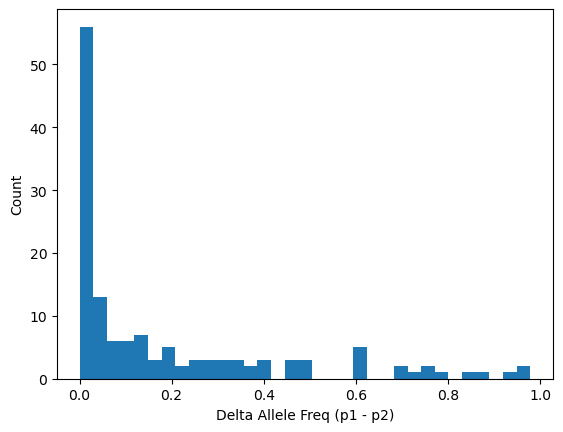

In [156]:
plt.hist(df["delta_af"], bins=33)
plt.xlabel("Delta Allele Freq (p1 - p2)")
plt.ylabel("Count")
plt.savefig("delta_af.png", dpi=600)
plt.show()

In [157]:
df.loc[df["delta_af"] > 0.95]

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
8,SM_V10_1,19941568,cuteSV.INS.883,C,CAATGTTGATAAGTAGAGATGGATAGTGGCTAGCAGTGGAATTCAG...,343,PASS,419,INS,SM_V10_1,...,1/1,36.0,"0,36","1548,108,0",0.000000,0.0,0.0,0.020833,1.0,0.979167
28,SM_V10_2,342555,cuteSV.DEL.3061,CAACTCTGGCGTTCGTCAGGGCTGTCCACTCTCCCCATTTTTGTTT...,C,238,PASS,-1221,DEL,SM_V10_2,...,1/1,30.0,"0,30","1290,90,0",0.041237,0.0,0.0,0.000000,1.0,0.958763


In [158]:
#shared SVs are present at >50% in 4 of 5 populations
af_cols = [f"af.{pop}" for pop in pops]

# Filter the DataFrame
tmp_df = df[df[af_cols].apply(lambda row: all(x > 0.95 or x < 0.05 for x in row), axis=1)]
tmp_df[tmp_df[af_cols].sum(axis=1) <= 4]

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
8,SM_V10_1,19941568,cuteSV.INS.883,C,CAATGTTGATAAGTAGAGATGGATAGTGGCTAGCAGTGGAATTCAG...,343,PASS,419,INS,SM_V10_1,...,1/1,36.0,"0,36","1548,108,0",0.000000,0.0,0.0,0.020833,1.00,0.979167
28,SM_V10_2,342555,cuteSV.DEL.3061,CAACTCTGGCGTTCGTCAGGGCTGTCCACTCTCCCCATTTTTGTTT...,C,238,PASS,-1221,DEL,SM_V10_2,...,1/1,30.0,"0,30","1290,90,0",0.041237,0.0,0.0,0.000000,1.00,0.958763
97,SM_V10_6,6022561,cuteSV.DEL.10928,TACTTAGTCGTGAAAGAACATACAATGTATTAGTGCCGGATAACGG...,T,209,PASS,-178,DEL,SM_V10_6,...,1/1,25.0,"1,24","1018,61,29",0.014925,0.0,0.0,0.000000,0.96,0.945075


In [159]:
ad_cols = [f"ad.{pop}" for pop in pops]
ls_df = tmp_df[tmp_df[af_cols].sum(axis=1) <= 4]
ls_df.to_csv("lineage_specific_svs.tsv", sep="\t", header=True, index=False)

ls_df[["chr", "pos", "end"] + ad_cols + af_cols]

,chr,pos,end,ad.smbre,ad.smeg,ad.smle-pzq-er,ad.smle-pzq-es,ad.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
8,SM_V10_1,19941568,19941568,"55,0","27,0","14,0","47,1","0,36",0.000000,0.0,0.0,0.020833,1.00
28,SM_V10_2,342555,343776,"46.5,2","16.5,0","10.5,0","48.5,0","0,30",0.041237,0.0,0.0,0.000000,1.00
97,SM_V10_6,6022561,6022739,"66,1","27,0","18.5,0","43,0","1,24",0.014925,0.0,0.0,0.000000,0.96


In [60]:
ls_df[["chr", "pos", "end", "id"]].to_csv("lineage_specific_svs.bed",  sep="\t", header=False, index=False)

In [62]:
%%bash

grep -i exon /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >smv10_exons.gtf

conda run -n bedtools --cwd . --live-stream bedtools intersect -a lineage_specific_svs.bed -b smv10_exons.gtf -u >lineage_specific_svs_in_exons.bed

cat lineage_specific_svs_in_exons.bed

SM_V10_6	6022562	6022741	Sniffles2.DEL.182DS5


In [160]:
tmp_df[tmp_df[af_cols].sum(axis=1) <= 4]["alt"]

8     CAATGTTGATAAGTAGAGATGGATAGTGGCTAGCAGTGGAATTCAG...
28                                                    C
97                                                    T
Name: alt, dtype: object

In [92]:
chr = record.CHROM
pos = record.POS
svtype = record.INFO["SVTYPE"]
vid = f"{chr}:{pos}:{svtype}"
vid

'SM_V10_Z:86685726:INS'

# Filter/Process SVs

In [24]:
Path("{}/results/process_svs".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/process_svs".format(proj_dir))

In [25]:
df=pd.read_csv(f"{proj_dir}/results/svjedi/merged.jedi.tsv", header=0, sep="\t")
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,32782,Sniffles2.DEL.196BS0,ATCATCCAAATCATCATCATCATCATCATCATCATCATCATCATCA...,N,57,PASS,-1670,DEL,SM_V10_1,...,"4,6","234,6,148",0/1,29.0,"12,17","654,10,438",./.,0.0,"0,0",".,.,."
1,SM_V10_1,49843,Sniffles2.DEL.431AS0,CCATTTACGGTTGACATTAGAATCACGGCTCGTATAATCCCCTACC...,N,60,PASS,-4788,DEL,SM_V10_1,...,"5.5,5","188,4,209",0/1,33.5,"24.5,9","311,24,977",./.,2.0,"2,0","0,6,86"
2,SM_V10_1,57384,Sniffles2.DEL.431ES0,AAATGTCTATCGTAATTAATAATCCGAAAAATTGGCCAGGTTAAAG...,N,60,PASS,-2774,DEL,SM_V10_1,...,"1.5,5","201,6,51",0/1,29.5,"19.5,10","355,14,763",./.,1.0,"1,0","0,3,43"
3,SM_V10_1,301595,Sniffles2.DEL.491FS0,AAATCTGTTTTGTAGCAATAATACCTTTATTTCCTGAACATTTATA...,N,60,PASS,-70,DEL,SM_V10_1,...,"37.5,1","27,99,1596",0/1,126.5,"114.5,12","353,217,4761",0/1,36.0,"23,13","465,14,895"
4,SM_V10_1,442440,Sniffles2.DEL.4F33S0,CACGACTCAATCCCTAACTTGGAATGGTGAAGGGAAGCGGAAAAGA...,N,58,PASS,-656,DEL,SM_V10_1,...,"4,0","0,12,172",0/1,18.0,"14,4","137,19,567",./.,0.0,"0,0",".,.,."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,SM_V10_Z,86591757,Sniffles2.DEL.986AS1,GAGATGGTGGAGAAGTTTGTGCTGATGATGTCGTTCAGAAGGACGA...,N,153,PASS,-109,DEL,SM_V10_Z,...,"3,0","0,9,129",0/1,29.5,"24.5,5","164,38,1003",0/0,21.5,"21.5,0","0,64,924"
4968,SM_V10_Z,86614394,Sniffles2.DEL.4DC4S1,TTCGTGTCGAGACTGTAAGGTCCTGGGTTCGAATCTCGCTAATGCG...,N,81,PASS,-713,DEL,SM_V10_Z,...,"2,5","201,7,72",0/1,58.0,"21,37","1436,19,747",0/1,53.0,"23,30","1142,11,841"
4969,SM_V10_Z,86621987,Sniffles2.DEL.4DCES1,ATACATGGTAGAATTATCCGTTTGACGTTTTCCGTACGTGACTTCG...,N,52,PASS,-155,DEL,SM_V10_Z,...,"3,0","0,9,129",0/1,29.0,"21,8","277,20,836",0/0,27.0,"27,0","0,81,1161"
4970,SM_V10_Z,86626775,Sniffles2.DEL.5701S1,AGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAG...,N,99,PASS,-302,DEL,SM_V10_Z,...,"0.5,0","0,1,21",0/0,17.0,"17,0","0,51,731",0/1,19.5,"4.5,15","609,22,157"


In [26]:
df = df.loc[df["filter"] == "PASS"]
df=df.reset_index(drop=True)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,32782,Sniffles2.DEL.196BS0,ATCATCCAAATCATCATCATCATCATCATCATCATCATCATCATCA...,N,57,PASS,-1670,DEL,SM_V10_1,...,"4,6","234,6,148",0/1,29.0,"12,17","654,10,438",./.,0.0,"0,0",".,.,."
1,SM_V10_1,49843,Sniffles2.DEL.431AS0,CCATTTACGGTTGACATTAGAATCACGGCTCGTATAATCCCCTACC...,N,60,PASS,-4788,DEL,SM_V10_1,...,"5.5,5","188,4,209",0/1,33.5,"24.5,9","311,24,977",./.,2.0,"2,0","0,6,86"
2,SM_V10_1,57384,Sniffles2.DEL.431ES0,AAATGTCTATCGTAATTAATAATCCGAAAAATTGGCCAGGTTAAAG...,N,60,PASS,-2774,DEL,SM_V10_1,...,"1.5,5","201,6,51",0/1,29.5,"19.5,10","355,14,763",./.,1.0,"1,0","0,3,43"
3,SM_V10_1,301595,Sniffles2.DEL.491FS0,AAATCTGTTTTGTAGCAATAATACCTTTATTTCCTGAACATTTATA...,N,60,PASS,-70,DEL,SM_V10_1,...,"37.5,1","27,99,1596",0/1,126.5,"114.5,12","353,217,4761",0/1,36.0,"23,13","465,14,895"
4,SM_V10_1,442440,Sniffles2.DEL.4F33S0,CACGACTCAATCCCTAACTTGGAATGGTGAAGGGAAGCGGAAAAGA...,N,58,PASS,-656,DEL,SM_V10_1,...,"4,0","0,12,172",0/1,18.0,"14,4","137,19,567",./.,0.0,"0,0",".,.,."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,SM_V10_Z,86591757,Sniffles2.DEL.986AS1,GAGATGGTGGAGAAGTTTGTGCTGATGATGTCGTTCAGAAGGACGA...,N,153,PASS,-109,DEL,SM_V10_Z,...,"3,0","0,9,129",0/1,29.5,"24.5,5","164,38,1003",0/0,21.5,"21.5,0","0,64,924"
4968,SM_V10_Z,86614394,Sniffles2.DEL.4DC4S1,TTCGTGTCGAGACTGTAAGGTCCTGGGTTCGAATCTCGCTAATGCG...,N,81,PASS,-713,DEL,SM_V10_Z,...,"2,5","201,7,72",0/1,58.0,"21,37","1436,19,747",0/1,53.0,"23,30","1142,11,841"
4969,SM_V10_Z,86621987,Sniffles2.DEL.4DCES1,ATACATGGTAGAATTATCCGTTTGACGTTTTCCGTACGTGACTTCG...,N,52,PASS,-155,DEL,SM_V10_Z,...,"3,0","0,9,129",0/1,29.0,"21,8","277,20,836",0/0,27.0,"27,0","0,81,1161"
4970,SM_V10_Z,86626775,Sniffles2.DEL.5701S1,AGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAG...,N,99,PASS,-302,DEL,SM_V10_Z,...,"0.5,0","0,1,21",0/0,17.0,"17,0","0,51,731",0/1,19.5,"4.5,15","609,22,157"


In [36]:
df["svtype"].value_counts()

svtype
DEL    4713
INV     158
DUP      99
INS       2
Name: count, dtype: int64

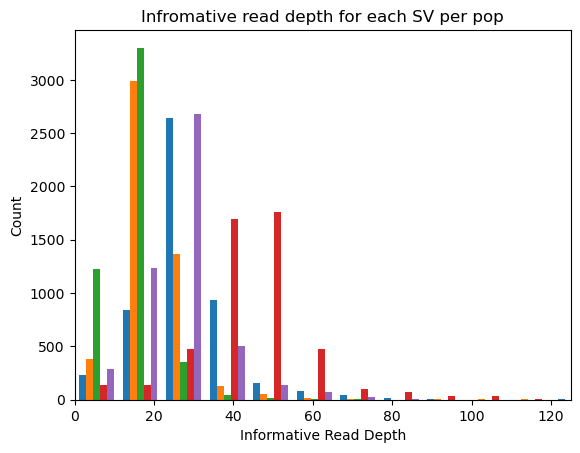

In [37]:
plt.hist(df[dp_cols], bins=100)
plt.xlabel("Informative Read Depth")
plt.ylabel("Count")
plt.title("Infromative read depth for each SV per pop")
# plt.legend()
plt.xlim([0, 125])
plt.show()

In [38]:
dp_cols = [f"dp.{pop}" for pop in pops]

depth_filter = (df[dp_cols] > 10) & (df[dp_cols] < 80)

depth_filter_idx = df[depth_filter.sum(axis=1) == 5].index

df = df.iloc[depth_filter_idx].reset_index(drop=True)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,ad.smle-pzq-er,pl.smle-pzq-er,gt.smle-pzq-es,dp.smle-pzq-es,ad.smle-pzq-es,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor
0,SM_V10_1,528244,Sniffles2.DEL.6CD0S0,GTATATAAACAATGAACTCCGCCTGTAGCTCCTCCAGGGGCTACTG...,N,96,PASS,-3214,DEL,SM_V10_1,...,"6,6","228,6,228",0/1,65.0,"24,41","1587,19,856",0/1,16.5,"13.5,3","100,21,552"
1,SM_V10_1,539821,Sniffles2.DEL.4941S0,CAGCTGTAGCAAATTCTTTCTTCCACGAAATGCTTAATGACGATAA...,N,57,PASS,-174,DEL,SM_V10_1,...,"14,0","0,42,602",0/1,78.0,"70,8","240,131,2907",0/1,23.0,"12,11","411,7,454"
2,SM_V10_1,644439,Sniffles2.DEL.4971S0,TATGAAAAGGATGAATAACAACTGGAAACAACTGGAAATGTTTGCC...,N,52,PASS,-563,DEL,SM_V10_1,...,"15.5,1","30,37,654",0/0,36.5,"34.5,2","58,81,1455",0/0,24.0,"23,1","29,58,975"
3,SM_V10_1,996897,Sniffles2.DEL.4FCBS0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,109,PASS,-242,DEL,SM_V10_1,...,"4,17","693,25,134",0/1,57.5,"9.5,48","1957,65,301",0/1,32.5,"11.5,21","817,12,409"
4,SM_V10_1,1024114,Sniffles2.DEL.1A2ES0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,N,257,PASS,-35018,DEL,SM_V10_1,...,"0,26","1118,78,0",1/1,67.0,"0,67","2881,201,0",1/1,44.0,"0,44","1892,132,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,SM_V10_Z,85632770,Sniffles2.DEL.20BFS1,AGTCTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACTA...,N,391,PASS,-5620,DEL,SM_V10_Z,...,"0,11","473,33,0",0/1,47.5,"3.5,44","1839,90,97",0/1,33.5,"13.5,20","768,9,489"
3544,SM_V10_Z,85663054,Sniffles2.DEL.20C3S1,CCCTGTTAGGATATTCACAAGAATATCCCAAAAATTATCTCGAATG...,N,410,PASS,-2784,DEL,SM_V10_Z,...,"0,13","559,39,0",1/1,47.0,"0,47","2021,141,0",0/1,27.5,"8.5,19","753,19,302"
3545,SM_V10_Z,85710327,Sniffles2.DEL.20C4S1,CGGGTAAAGGAGGAGGGTTGGGCATGGGGTTAGCGACCTCATCCCG...,N,400,PASS,-161,DEL,SM_V10_Z,...,"5,12","478,13,177",0/1,46.0,"7,39","1600,61,223",0/1,24.0,"12,12","451,7,451"
3546,SM_V10_Z,85883040,Sniffles2.DEL.4D36S1,TGCTGCTACCTTGACGTGGTGGTCGGGCTTGCCTATCGTGATGATC...,N,130,PASS,-3931,DEL,SM_V10_Z,...,"10.5,0","0,31,451",0/0,31.5,"31.5,0","0,94,1354",0/0,26.0,"26,0","0,78,1118"


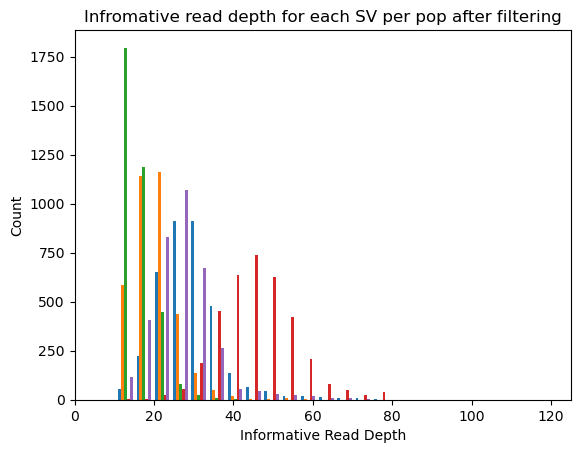

In [39]:
dp_cols = [f"dp.{pop}" for pop in pops]

plt.hist(df[dp_cols], bins=15)
plt.xlabel("Informative Read Depth")
plt.ylabel("Count")
plt.title("Infromative read depth for each SV per pop after filtering")
# plt.legend()
plt.xlim([0, 125])
plt.show()

In [40]:
ad_cols = [f"ad.{pop}" for pop in pops]

for pop in pops:
    alt_ad_s = [float(ad.split(",")[1]) for ad in df[f"ad.{pop}"]]
    dp_s = df[f"dp.{pop}"].astype(float)
    af_s = alt_ad_s/dp_s
    df[f"af.{pop}"]=af_s

df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
0,SM_V10_1,528244,Sniffles2.DEL.6CD0S0,GTATATAAACAATGAACTCCGCCTGTAGCTCCTCCAGGGGCTACTG...,N,96,PASS,-3214,DEL,SM_V10_1,...,"1587,19,856",0/1,16.5,"13.5,3","100,21,552",0.066667,0.521739,0.500000,0.630769,0.181818
1,SM_V10_1,539821,Sniffles2.DEL.4941S0,CAGCTGTAGCAAATTCTTTCTTCCACGAAATGCTTAATGACGATAA...,N,57,PASS,-174,DEL,SM_V10_1,...,"240,131,2907",0/1,23.0,"12,11","411,7,454",0.000000,0.000000,0.000000,0.102564,0.478261
2,SM_V10_1,644439,Sniffles2.DEL.4971S0,TATGAAAAGGATGAATAACAACTGGAAACAACTGGAAATGTTTGCC...,N,52,PASS,-563,DEL,SM_V10_1,...,"58,81,1455",0/0,24.0,"23,1","29,58,975",0.054054,0.050000,0.060606,0.054795,0.041667
3,SM_V10_1,996897,Sniffles2.DEL.4FCBS0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,109,PASS,-242,DEL,SM_V10_1,...,"1957,65,301",0/1,32.5,"11.5,21","817,12,409",0.716981,0.885714,0.809524,0.834783,0.646154
4,SM_V10_1,1024114,Sniffles2.DEL.1A2ES0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,N,257,PASS,-35018,DEL,SM_V10_1,...,"2881,201,0",1/1,44.0,"0,44","1892,132,0",1.000000,0.956522,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,SM_V10_Z,85632770,Sniffles2.DEL.20BFS1,AGTCTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACTA...,N,391,PASS,-5620,DEL,SM_V10_Z,...,"1839,90,97",0/1,33.5,"13.5,20","768,9,489",0.892308,1.000000,1.000000,0.926316,0.597015
3544,SM_V10_Z,85663054,Sniffles2.DEL.20C3S1,CCCTGTTAGGATATTCACAAGAATATCCCAAAAATTATCTCGAATG...,N,410,PASS,-2784,DEL,SM_V10_Z,...,"2021,141,0",0/1,27.5,"8.5,19","753,19,302",0.950820,1.000000,1.000000,1.000000,0.690909
3545,SM_V10_Z,85710327,Sniffles2.DEL.20C4S1,CGGGTAAAGGAGGAGGGTTGGGCATGGGGTTAGCGACCTCATCCCG...,N,400,PASS,-161,DEL,SM_V10_Z,...,"1600,61,223",0/1,24.0,"12,12","451,7,451",0.742857,0.642857,0.705882,0.847826,0.500000
3546,SM_V10_Z,85883040,Sniffles2.DEL.4D36S1,TGCTGCTACCTTGACGTGGTGGTCGGGCTTGCCTATCGTGATGATC...,N,130,PASS,-3931,DEL,SM_V10_Z,...,"0,94,1354",0/0,26.0,"26,0","0,78,1118",0.676471,0.470588,0.000000,0.000000,0.000000


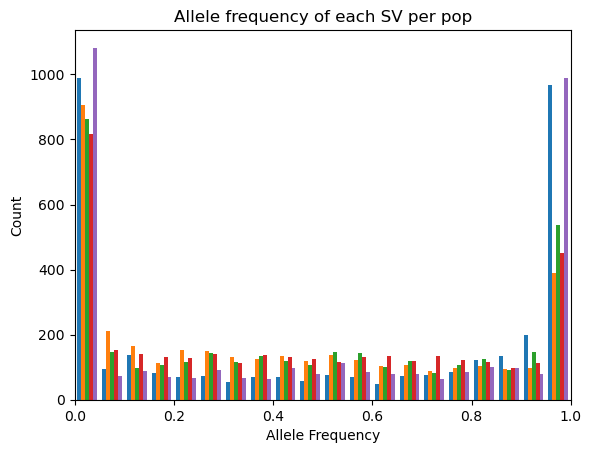

In [41]:
af_cols = [f"af.{pop}" for pop in pops]

plt.hist(df[af_cols], bins=20)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Allele frequency of each SV per pop")
# plt.legend()
plt.xlim([0, 1])
plt.show()

In [42]:
#shared SVs are present at >50% in 4 of 5 populations
af_cols = [f"af.{pop}" for pop in pops]


shared_conditions = (df[af_cols] > 0.5)
fixed_conditions = (df[af_cols]  > 0.95)

shared_idx = df[shared_conditions.sum(axis=1) == 5].index
fixed_idx  = df[fixed_conditions.sum(axis=1) >= 1].index

idxs=list(set(list(shared_idx) + list(fixed_idx)))
idxs.sort()

df = df.iloc[idxs].reset_index(drop=True)

df = df[~df[af_cols].isin(['.']).any(axis=1)].reset_index(drop=True)

df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,pl.smle-pzq-es,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
0,SM_V10_1,996897,Sniffles2.DEL.4FCBS0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,109,PASS,-242,DEL,SM_V10_1,...,"1957,65,301",0/1,32.5,"11.5,21","817,12,409",0.716981,0.885714,0.809524,0.834783,0.646154
1,SM_V10_1,1024114,Sniffles2.DEL.1A2ES0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,N,257,PASS,-35018,DEL,SM_V10_1,...,"2881,201,0",1/1,44.0,"0,44","1892,132,0",1.000000,0.956522,1.000000,1.000000,1.000000
2,SM_V10_1,1244994,Sniffles2.DEL.1A66S0,TTTATTGATGGTTGACATTAGAATCACTGCACGTATAATCCCCTAT...,N,238,PASS,-4872,DEL,SM_V10_1,...,"629,12,263",0/1,19.0,"5,14","561,16,174",1.000000,0.869565,0.833333,0.680851,0.736842
3,SM_V10_1,1569376,Sniffles2.DEL.1A94S0,TGCTTGTTGATCATTGGTCACTTTCAAAACTCAGAGCATTGTAAAT...,N,257,PASS,-1268,DEL,SM_V10_1,...,"1434,78,36",0/1,22.0,"2,20","836,42,62",0.952381,0.692308,1.000000,0.957746,0.909091
4,SM_V10_1,2059168,Sniffles2.DEL.1AFAS0,AAACTGATTATAATCAGAAGGGGTTTTGTGGAGATTTTAGTATTTT...,N,524,PASS,-347,DEL,SM_V10_1,...,"2322,162,0",1/1,29.0,"0,29","1247,87,0",1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,SM_V10_Z,84315130,Sniffles2.DEL.2073S1,GCATAGCATTGTAACTCCGCCTGTAGCTCCTCCAGGGGCTACTGCC...,N,267,PASS,-3220,DEL,SM_V10_Z,...,"1447,62,156",0/1,33.0,"5,28","1150,45,161",0.562500,0.722222,1.000000,0.875000,0.848485
1550,SM_V10_Z,84672814,Sniffles2.DEL.207CS1,AACCTTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACT...,N,343,PASS,-5606,DEL,SM_V10_Z,...,"1548,108,0",1/1,25.0,"0,25","1075,75,0",1.000000,1.000000,1.000000,1.000000,1.000000
1551,SM_V10_Z,85427536,Sniffles2.DEL.972BS1,ATACTGTAGTGAACAAAACACTGGTTGGGGACAATCGAATGTATTT...,N,295,PASS,-990,DEL,SM_V10_Z,...,"1548,108,0",0/1,22.0,"9,13","502,9,330",0.151515,0.545455,0.866667,1.000000,0.590909
1552,SM_V10_Z,85632770,Sniffles2.DEL.20BFS1,AGTCTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACTA...,N,391,PASS,-5620,DEL,SM_V10_Z,...,"1839,90,97",0/1,33.5,"13.5,20","768,9,489",0.892308,1.000000,1.000000,0.926316,0.597015


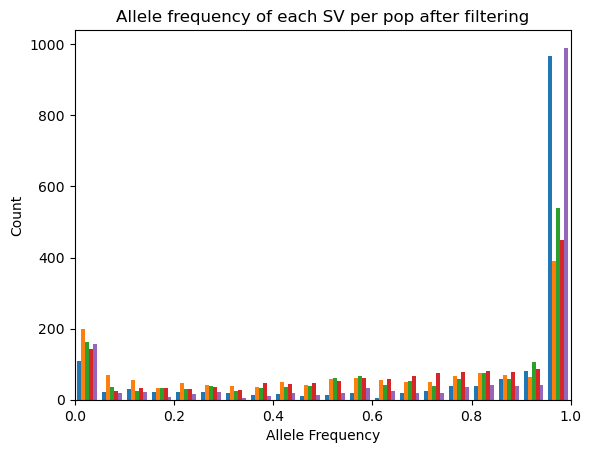

In [43]:
af_cols = [f"af.{pop}" for pop in pops]

plt.hist(df[af_cols], bins=20)
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Allele frequency of each SV per pop after filtering")
# plt.legend()
plt.xlim([0, 1])
plt.show()

In [44]:
af_diffs=[]
af_cols = [f"af.{pop}" for pop in pops]


for index, row in df[af_cols].iterrows():
    afs=list(row[af_cols])
    afs.sort()
    af_diffs.append(afs[-1] - afs[-2])


df["delta_af"] = af_diffs

df.to_csv("processed_svs.tsv", sep="\t", header=True, index=False)
df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
0,SM_V10_1,996897,Sniffles2.DEL.4FCBS0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,109,PASS,-242,DEL,SM_V10_1,...,0/1,32.5,"11.5,21","817,12,409",0.716981,0.885714,0.809524,0.834783,0.646154,0.050932
1,SM_V10_1,1024114,Sniffles2.DEL.1A2ES0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,N,257,PASS,-35018,DEL,SM_V10_1,...,1/1,44.0,"0,44","1892,132,0",1.000000,0.956522,1.000000,1.000000,1.000000,0.000000
2,SM_V10_1,1244994,Sniffles2.DEL.1A66S0,TTTATTGATGGTTGACATTAGAATCACTGCACGTATAATCCCCTAT...,N,238,PASS,-4872,DEL,SM_V10_1,...,0/1,19.0,"5,14","561,16,174",1.000000,0.869565,0.833333,0.680851,0.736842,0.130435
3,SM_V10_1,1569376,Sniffles2.DEL.1A94S0,TGCTTGTTGATCATTGGTCACTTTCAAAACTCAGAGCATTGTAAAT...,N,257,PASS,-1268,DEL,SM_V10_1,...,0/1,22.0,"2,20","836,42,62",0.952381,0.692308,1.000000,0.957746,0.909091,0.042254
4,SM_V10_1,2059168,Sniffles2.DEL.1AFAS0,AAACTGATTATAATCAGAAGGGGTTTTGTGGAGATTTTAGTATTTT...,N,524,PASS,-347,DEL,SM_V10_1,...,1/1,29.0,"0,29","1247,87,0",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,SM_V10_Z,84315130,Sniffles2.DEL.2073S1,GCATAGCATTGTAACTCCGCCTGTAGCTCCTCCAGGGGCTACTGCC...,N,267,PASS,-3220,DEL,SM_V10_Z,...,0/1,33.0,"5,28","1150,45,161",0.562500,0.722222,1.000000,0.875000,0.848485,0.125000
1550,SM_V10_Z,84672814,Sniffles2.DEL.207CS1,AACCTTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACT...,N,343,PASS,-5606,DEL,SM_V10_Z,...,1/1,25.0,"0,25","1075,75,0",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1551,SM_V10_Z,85427536,Sniffles2.DEL.972BS1,ATACTGTAGTGAACAAAACACTGGTTGGGGACAATCGAATGTATTT...,N,295,PASS,-990,DEL,SM_V10_Z,...,0/1,22.0,"9,13","502,9,330",0.151515,0.545455,0.866667,1.000000,0.590909,0.133333
1552,SM_V10_Z,85632770,Sniffles2.DEL.20BFS1,AGTCTGTAGTGGATGTCGAGTCGTGGACGGACTATGATCACCACTA...,N,391,PASS,-5620,DEL,SM_V10_Z,...,0/1,33.5,"13.5,20","768,9,489",0.892308,1.000000,1.000000,0.926316,0.597015,0.000000


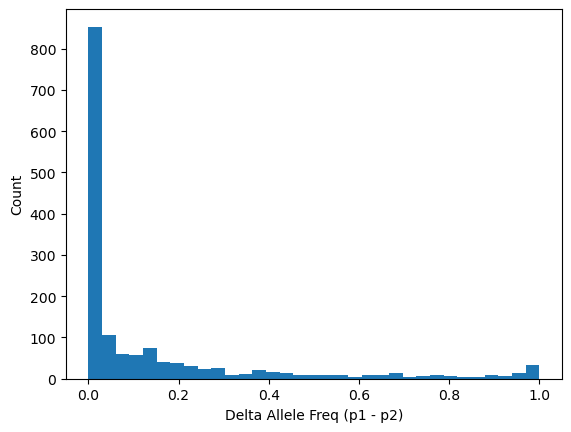

In [45]:
plt.hist(df["delta_af"], bins=33)
plt.xlabel("Delta Allele Freq (p1 - p2)")
plt.ylabel("Count")
plt.savefig("delta_af.png", dpi=600)
plt.show()

In [46]:
df.loc[df["delta_af"] > 0.95]

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
74,SM_V10_1,20567929,Sniffles2.DEL.52CDS0,CATAAATAATATGAATTCAACTTAGTATTGTTTGTTTGAATCTTCC...,N,171,PASS,-170,DEL,SM_V10_1,...,1/1,17.0,"0,17","731,51,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000
263,SM_V10_1,76815039,Sniffles2.INV.86D7S0,N,<INV>,276,PASS,828,INV,SM_V10_1,...,0/0,36.0,"36,0","0,108,1548",0.984127,0.000000,0.0,0.014085,0.000000,0.970042
294,SM_V10_1,83035676,Sniffles2.DEL.6B37S0,AAAGATTGGTTTTGTAATGTGCTTACACCATTGGAAGTCAAAAATA...,N,334,PASS,-105,DEL,SM_V10_1,...,1/1,34.0,"0,34","1462,102,0",0.000000,0.000000,0.0,0.026316,1.000000,0.973684
316,SM_V10_2,261974,Sniffles2.DEL.280DS4,AGTTTCTGTTGTATCCCCTGGCGAATTATGAATCGTAAATCTGAGG...,N,181,PASS,-445,DEL,SM_V10_2,...,1/1,14.0,"0,14","602,42,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000
317,SM_V10_2,273647,Sniffles2.DEL.2814S4,ACTACTGTTGTGAACAAAAACACTAGTTGGGGACAACCAAATGTGC...,N,190,PASS,-309,DEL,SM_V10_2,...,1/1,17.0,"0,17","731,51,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000
319,SM_V10_2,286494,Sniffles2.DEL.2818S4,AGTGAATTTAAACTTCACCCCATTGCACAAGCAAGTGGCTATCAGG...,N,248,PASS,-405,DEL,SM_V10_2,...,1/1,25.0,"0,25","1075,75,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000
321,SM_V10_2,381107,Sniffles2.DEL.2823S4,CATCGATGCTCGCATCTGCTGGGATCACCGGGTAAATAATAGTGAG...,N,181,PASS,-644,DEL,SM_V10_2,...,1/1,28.0,"0,28","1204,84,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000
332,SM_V10_2,537012,Sniffles2.DEL.2844S4,GGCAATCAATAACTTACCCACAATCGATTAACATTCATAAAAAATA...,N,229,PASS,-232,DEL,SM_V10_2,...,1/1,24.0,"0,24","1032,72,0",0.041667,0.000000,0.0,0.000000,1.000000,0.958333
335,SM_V10_2,610712,Sniffles2.DEL.2852S4,CACAAGATTTATTTATTTAAACGCATAAATATTGGTACAAGGAAGC...,N,219,PASS,-78,DEL,SM_V10_2,...,1/1,23.0,"0,23","989,69,0",0.000000,0.000000,0.0,0.018868,1.000000,0.981132
336,SM_V10_2,619244,Sniffles2.DEL.2853S4,TCATCTTGGTGACCGTCAGGTGGTGATCTAAAGCTATATCAGTTCC...,N,219,PASS,-521,DEL,SM_V10_2,...,1/1,29.0,"0,29","1247,87,0",0.000000,0.000000,0.0,0.000000,1.000000,1.000000


In [47]:
#shared SVs are present at >50% in 4 of 5 populations
af_cols = [f"af.{pop}" for pop in pops]

# Filter the DataFrame
tmp_df = df[df[af_cols].apply(lambda row: all(x > 0.95 or x < 0.05 for x in row), axis=1)]
tmp_df[tmp_df[af_cols].sum(axis=1) <= 4]

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
69,SM_V10_1,20070227,Sniffles2.DEL.52A3S0,TCGATAGTACTATTTTGTGTGAAAATGTTTTTTATAAGTATTGCAT...,N,257,PASS,-1997,DEL,SM_V10_1,...,1/1,33.0,"1,32","1361,84,27",0.000000,0.037037,0.000000,0.000000,0.969697,0.932660
74,SM_V10_1,20567929,Sniffles2.DEL.52CDS0,CATAAATAATATGAATTCAACTTAGTATTGTTTGTTTGAATCTTCC...,N,171,PASS,-170,DEL,SM_V10_1,...,1/1,17.0,"0,17","731,51,0",0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
141,SM_V10_1,39851523,Sniffles2.DEL.216FS0,GTAATCCTGATACACAGAAAAAATTTTCAGCATAAATAATATTGGC...,N,400,PASS,-600,DEL,SM_V10_1,...,1/1,40.0,"0,40","1720,120,0",1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
263,SM_V10_1,76815039,Sniffles2.INV.86D7S0,N,<INV>,276,PASS,828,INV,SM_V10_1,...,0/0,36.0,"36,0","0,108,1548",0.984127,0.000000,0.000000,0.014085,0.000000,0.970042
294,SM_V10_1,83035676,Sniffles2.DEL.6B37S0,AAAGATTGGTTTTGTAATGTGCTTACACCATTGGAAGTCAAAAATA...,N,334,PASS,-105,DEL,SM_V10_1,...,1/1,34.0,"0,34","1462,102,0",0.000000,0.000000,0.000000,0.026316,1.000000,0.973684
316,SM_V10_2,261974,Sniffles2.DEL.280DS4,AGTTTCTGTTGTATCCCCTGGCGAATTATGAATCGTAAATCTGAGG...,N,181,PASS,-445,DEL,SM_V10_2,...,1/1,14.0,"0,14","602,42,0",0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
317,SM_V10_2,273647,Sniffles2.DEL.2814S4,ACTACTGTTGTGAACAAAAACACTAGTTGGGGACAACCAAATGTGC...,N,190,PASS,-309,DEL,SM_V10_2,...,1/1,17.0,"0,17","731,51,0",0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
319,SM_V10_2,286494,Sniffles2.DEL.2818S4,AGTGAATTTAAACTTCACCCCATTGCACAAGCAAGTGGCTATCAGG...,N,248,PASS,-405,DEL,SM_V10_2,...,1/1,25.0,"0,25","1075,75,0",0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
321,SM_V10_2,381107,Sniffles2.DEL.2823S4,CATCGATGCTCGCATCTGCTGGGATCACCGGGTAAATAATAGTGAG...,N,181,PASS,-644,DEL,SM_V10_2,...,1/1,28.0,"0,28","1204,84,0",0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
332,SM_V10_2,537012,Sniffles2.DEL.2844S4,GGCAATCAATAACTTACCCACAATCGATTAACATTCATAAAAAATA...,N,229,PASS,-232,DEL,SM_V10_2,...,1/1,24.0,"0,24","1032,72,0",0.041667,0.000000,0.000000,0.000000,1.000000,0.958333


In [53]:
ad_cols = [f"ad.{pop}" for pop in pops]
ls_df = tmp_df[tmp_df[af_cols].sum(axis=1) <= 4]
ls_df.to_csv("lineage_specific_svs.tsv", sep="\t", header=True, index=False)

ls_df[["chr", "pos", "end"] + ad_cols + af_cols]

,chr,pos,end,ad.smbre,ad.smeg,ad.smle-pzq-er,ad.smle-pzq-es,ad.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor
69,SM_V10_1,20070227,20072225,"30,0","26,1","15,0","51,0","1,32",0.000000,0.037037,0.000000,0.000000,0.969697
74,SM_V10_1,20567929,20568100,"28,0","17.5,0","13,0","48,0","0,17",0.000000,0.000000,0.000000,0.000000,1.000000
141,SM_V10_1,39851523,39852123,"0,27","16.5,0","0,16","0,45","0,40",1.000000,0.000000,1.000000,1.000000,1.000000
263,SM_V10_1,76815039,76815868,"1,62","42,0","35,0","70,1","36,0",0.984127,0.000000,0.000000,0.014085,0.000000
294,SM_V10_1,83035676,83035781,"34,0","12,0","19,0","37,1","0,34",0.000000,0.000000,0.000000,0.026316,1.000000
316,SM_V10_2,261974,262419,"34,0","14,0","15,0","46,0","0,14",0.000000,0.000000,0.000000,0.000000,1.000000
317,SM_V10_2,273647,273956,"25,0","21,0","14,0","51,0","0,17",0.000000,0.000000,0.000000,0.000000,1.000000
319,SM_V10_2,286494,286899,"31,0","21.5,0","19,0","45.5,0","0,25",0.000000,0.000000,0.000000,0.000000,1.000000
321,SM_V10_2,381107,381751,"35,0","24,0","16.5,0","45.5,0","0,28",0.000000,0.000000,0.000000,0.000000,1.000000
332,SM_V10_2,537012,537245,"23,1","23.5,0","25.5,0","50,0","0,24",0.041667,0.000000,0.000000,0.000000,1.000000


In [60]:
ls_df[["chr", "pos", "end", "id"]].to_csv("lineage_specific_svs.bed",  sep="\t", header=False, index=False)

In [62]:
%%bash

grep -i exon /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >smv10_exons.gtf

conda run -n bedtools --cwd . --live-stream bedtools intersect -a lineage_specific_svs.bed -b smv10_exons.gtf -u >lineage_specific_svs_in_exons.bed

cat lineage_specific_svs_in_exons.bed

SM_V10_6	6022562	6022741	Sniffles2.DEL.182DS5


# PCA of SV AFs

In [679]:
Path("{}/results/pca".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/pca".format(proj_dir))

In [680]:
tmp_df=pd.read_csv(f"{proj_dir}/results/process_svs/processed_svs.tsv", sep="\t", header=0)
auto_df = tmp_df.loc[~tmp_df["chr"].isin(["SM_V10_Z", "SM_V10_MITO", "SM_V10_WSR"])].reset_index(drop=True)
auto_df

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af
0,SM_V10_1,996897,Sniffles2.DEL.4FCBS0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,109,PASS,-242,DEL,SM_V10_1,...,0/1,32.5,"11.5,21","817,12,409",0.745098,0.876712,0.809524,0.842105,0.646154,0.034607
1,SM_V10_1,2572354,Sniffles2.DEL.6FA5S0,TAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTA...,N,230,PASS,-478,DEL,SM_V10_1,...,0/1,28.0,"3,25","1040,49,93",0.687500,0.750000,0.750000,0.603774,0.892857,0.142857
2,SM_V10_1,2657239,Sniffles2.DEL.6FB9S0,CTGGTACGAGAAGGCAGTGAGTCGGCCATGTGAGAGCATTTCGAGA...,N,86,PASS,-791,DEL,SM_V10_1,...,0/1,25.0,"19,6","205,22,764",1.000000,0.432432,0.916667,0.738739,0.240000,0.083333
3,SM_V10_1,2664707,Sniffles2.DEL.4609S0,AGAATCTCCCAGTAAAATCTGAGAATCATATGGTAAATACGTTCAT...,N,133,PASS,-182,DEL,SM_V10_1,...,1/1,24.0,"0,24","1032,72,0",1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,SM_V10_1,3308666,Sniffles2.INS.1B2S0,N,TACTACTACTCTCTTACTACTACTACTACTACTACTACTACTACTA...,105,PASS,165,INS,SM_V10_1,...,0/1,13.0,"5,8","312,8,183",0.000000,0.259259,1.000000,0.750000,0.615385,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,SM_V10_7,18650978,Sniffles2.INS.E48S7,N,ATTTTCCTCGTTGAAAAATCTACGAGGACACTCCAAAAAAGTTCAC...,57,PASS,252,INS,SM_V10_7,...,0/1,12.0,"1,11","462,25,32",0.696970,0.666667,1.000000,0.489362,0.916667,0.083333
994,SM_V10_7,18854854,Sniffles2.DEL.17E1S7,TTGTTGAAAGGTCTTGAAGTAGAACTACACAATAACCCTGCCCCAG...,N,143,PASS,-382,DEL,SM_V10_7,...,0/1,22.5,"3.5,19","777,28,111",1.000000,0.866667,0.944444,0.455446,0.844444,0.055556
995,SM_V10_7,18983721,Sniffles2.DEL.A3AS7,TAAACAAGATTTTCCATGGTGGTCTAGCTTCAATTGACTCACGCTT...,N,143,PASS,-56,DEL,SM_V10_7,...,1/1,17.0,"0,17","731,51,0",0.777778,0.611111,0.928571,0.152542,1.000000,0.071429
996,SM_V10_7,19270178,Sniffles2.DEL.AB6S7,CTATCCAAACATCATCATCAACATCATCAAAATCATCTTCTGAATC...,N,91,PASS,-73,DEL,SM_V10_7,...,0/1,45.0,"24,21","777,9,906",1.000000,0.142857,0.700000,0.066667,0.466667,0.300000


In [681]:
# Standardize the features you want to use for PCA
af_cols = [f"af.{pop}" for pop in pops]
features_to_standardize = af_cols

#features_to_standardize = [f"{pop}_af" for pop in pops]

x = StandardScaler().fit_transform(auto_df[features_to_standardize].transpose())

In [682]:
# Apply PCA
pca = PCA(n_components=5)  # Reduce to 2 components for the sake of visualization
principal_components = pca.fit_transform(x)

In [683]:
# Convert to DataFrame for easier visualization
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [686]:
principal_df["pops"]=[x.replace("_af", "") for x in list(auto_df[features_to_standardize].transpose().index)]
principal_df.to_csv("pca.csv", sep=",", header=True, index=False)
principal_df


,PC1,PC2,PC3,PC4,PC5,pops
0,21.081140,-14.211409,20.721809,-1.504194,6.775443e-15,af.smbre
1,-20.697027,22.574791,13.741980,-1.259772,6.775443e-15,af.smeg
2,-12.863544,-12.295120,-12.010686,-16.466601,6.775443e-15,af.smle-pzq-er
3,-13.971887,-12.484544,-7.099708,17.684300,6.775443e-15,af.smle-pzq-es
4,26.451318,16.416282,-15.353395,1.546266,6.775443e-15,af.smor


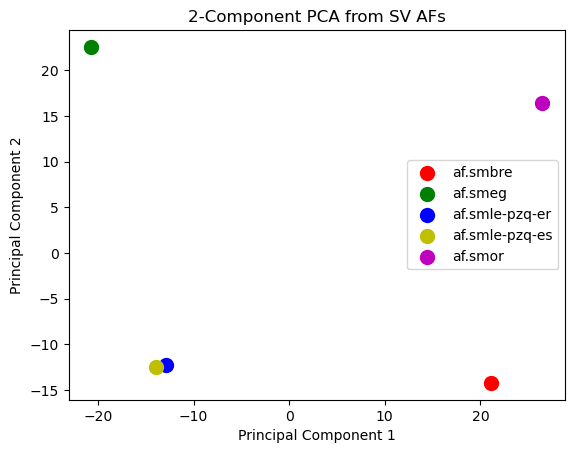

In [687]:
# Visualization

# Define a color map for the unique population labels
colors = ['r', 'g', 'b', 'y', 'm', "black"]
pop_colors = {pop: colors[i] for i, pop in enumerate(principal_df['pops'].unique())}

for pop, color in pop_colors.items():
    subset = principal_df[principal_df['pops'] == pop]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=pop, s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2-Component PCA from SV AFs')
plt.legend(loc='best')  # Display the legend
plt.savefig("pca_selected_svs_freq.png", dpi=300)
plt.savefig("pca_selected_svs_freq.svg")
plt.show()

# SmLE_PZQ_ER and ES comparisons:

In [688]:
Path("{}/results/er_vs_es".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/er_vs_es".format(proj_dir))

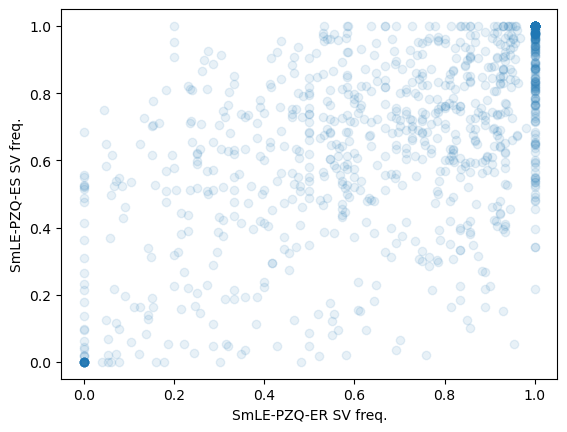

In [689]:
tmp_df=pd.read_csv(f"{proj_dir}/results/process_svs/processed_svs.tsv", sep="\t", header=0)
auto_df = tmp_df.loc[~tmp_df["chr"].isin(["SM_V10_Z", "SM_V10_MITO", "SM_V10_WSR"])].reset_index(drop=True)
auto_df

plt.scatter(auto_df["af.smle-pzq-er"], auto_df["af.smle-pzq-es"], alpha=0.1)
plt.xlabel("SmLE-PZQ-ER SV freq.")
plt.ylabel("SmLE-PZQ-ES SV freq.")
plt.savefig("er_vs_es_scatter.png", dpi=600)
plt.show()

In [690]:
er_svs = set(auto_df.loc[ (auto_df["af.smle-pzq-er"] - auto_df["af.smle-pzq-es"] >  0.95), "id"])

In [691]:
auto_df.loc[auto_df["id"].isin(er_svs)]

,chr,pos,id,ref,alt,qual,filter,svlen,svtype,chr2,...,gt.smor,dp.smor,ad.smor,pl.smor,af.smbre,af.smeg,af.smle-pzq-er,af.smle-pzq-es,af.smor,delta_af


/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


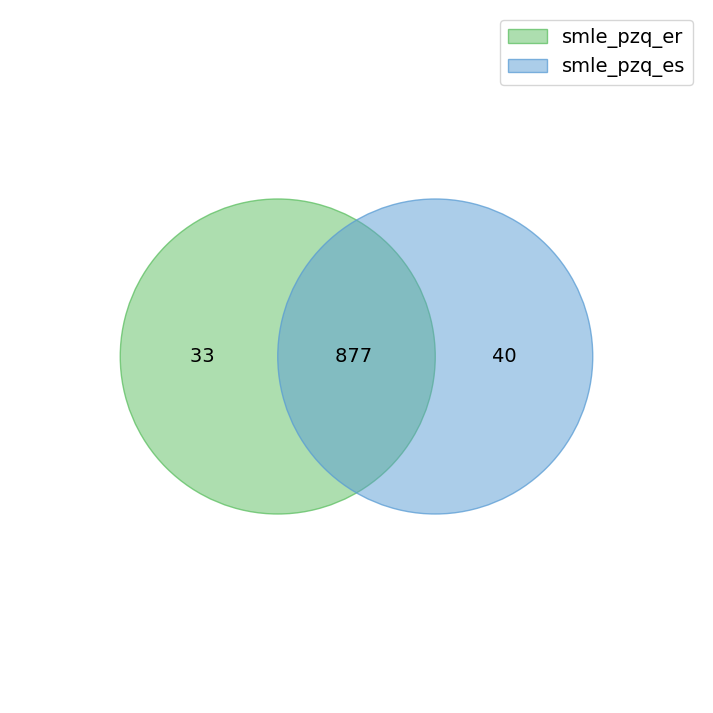

In [692]:
er_svs = set(auto_df.loc[auto_df["af.smle-pzq-er"] > 0.15, "id"])
es_svs = set(auto_df.loc[auto_df["af.smle-pzq-es"] > 0.15, "id"])

labels = venn.get_labels([ er_svs, es_svs ], fill=['number'])

fig, ax = venn.venn2(labels, names=['smle_pzq_er', 'smle_pzq_es'])
fig.show()
fig.savefig("er_vs_es_venn.png", dpi=600)

# Uniq SVs per pop

In [693]:
Path("{}/results/pop_specific_svs".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/pop_specific_svs".format(proj_dir))

In [694]:
tmp_df=pd.read_csv(f"{proj_dir}/results/process_svs/processed_svs.tsv", sep="\t", header=0)
auto_df = tmp_df.loc[~tmp_df["chr"].isin(["SM_V10_Z", "SM_V10_MITO", "SM_V10_WSR"])].reset_index(drop=True)

In [695]:
er_svs = set(auto_df.loc[auto_df["af.smle-pzq-er"] > 0.15, "id"])
es_svs = set(auto_df.loc[auto_df["af.smle-pzq-es"] > 0.15, "id"])
eg_svs = set(auto_df.loc[auto_df["af.smeg"] > 0.15, "id"])
or_svs = set(auto_df.loc[auto_df["af.smor"] > 0.15, "id"])
bre_svs = set(auto_df.loc[auto_df["af.smbre"] > 0.15, "id"])

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


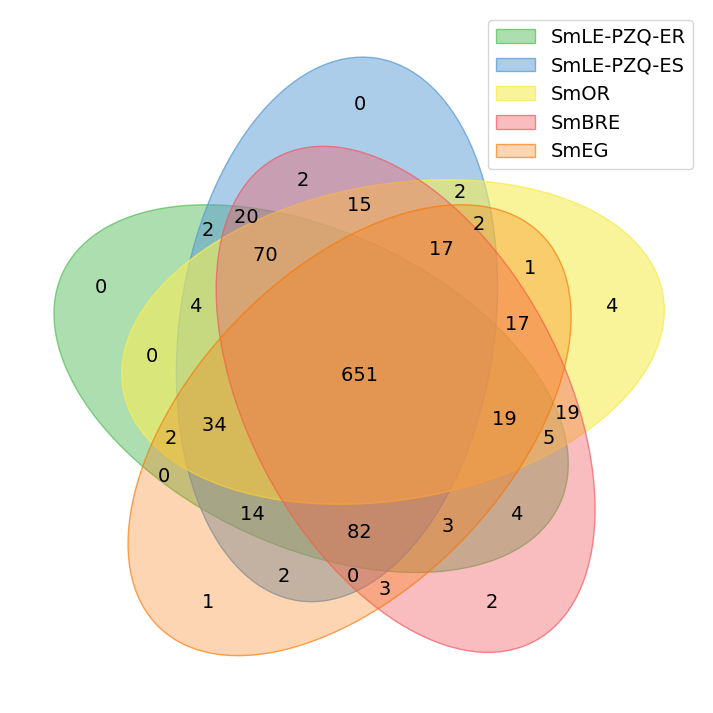

In [697]:
labels = venn.get_labels([ er_svs, es_svs, or_svs, bre_svs, eg_svs ], fill=['number'])

fig, ax = venn.venn2(labels, names=['SmLE-PZQ-ER', 'SmLE-PZQ-ES', 'SmOR', 'SmBRE', 'SmEG'])
fig.show()
fig.savefig("svs_venn.png", dpi=600)

# exons impacted by svs (debreak only)

In [ ]:
Path("{}/results/svs_in_genes".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/svs_in_genes".format(proj_dir))

In [742]:
shared_vars={}

for pop in pops:
    debr_df = pd.read_csv(f"{pop}.debreak.exons.bed", sep="\t", header=None)
    debr_df.columns=["chr", "start", "stop", "id"]
    
    cute_df = pd.read_csv(f"{pop}.cutesv.exons.bed", sep="\t", header=None)
    cute_df.columns=["chr", "start", "stop", "id"]
    
    sniff_df = pd.read_csv(f"{pop}.sniffles.exons.bed", sep="\t", header=None)
    sniff_df.columns=["chr", "start", "stop", "id"]

    debr = set(debr_df[["chr", "start"]].apply(lambda row: f'{row["chr"]}:{row["start"]}', axis=1))
    cute = set(cute_df[["chr", "start"]].apply(lambda row: f'{row["chr"]}:{row["start"]}', axis=1))
    sniff = set(sniff_df[["chr", "start"]].apply(lambda row: f'{row["chr"]}:{row["start"]}', axis=1))

    shared_vars[pop] = debr & cute & sniff

    print(f"{pop}: {len(shared_vars[pop])}")

smbre: 44
smeg: 16
smle-pzq-er: 26
smle-pzq-es: 42
smor: 35


In [738]:
shared_vars

{'smbre': {'SM_V10_1:16630368',
  'SM_V10_1:21451315',
  'SM_V10_1:39678596',
  'SM_V10_1:44200171',
  'SM_V10_1:56686826',
  'SM_V10_1:58114777',
  'SM_V10_1:62427541',
  'SM_V10_1:75481800',
  'SM_V10_1:86048688',
  'SM_V10_1:87375786',
  'SM_V10_2:22265640',
  'SM_V10_2:34102823',
  'SM_V10_2:40018702',
  'SM_V10_2:6937180',
  'SM_V10_3:25980574',
  'SM_V10_3:30695978',
  'SM_V10_3:34415064',
  'SM_V10_3:3452615',
  'SM_V10_3:34623300',
  'SM_V10_3:3516803',
  'SM_V10_3:4062139',
  'SM_V10_3:8111104',
  'SM_V10_4:20885619',
  'SM_V10_4:35912899',
  'SM_V10_5:11576539',
  'SM_V10_5:15469471',
  'SM_V10_5:20215206',
  'SM_V10_5:23040161',
  'SM_V10_5:23994421',
  'SM_V10_5:4303460',
  'SM_V10_5:4307478',
  'SM_V10_6:12688114',
  'SM_V10_7:13717399',
  'SM_V10_7:14477636',
  'SM_V10_7:18983721',
  'SM_V10_7:5273654',
  'SM_V10_Z:16980180',
  'SM_V10_Z:42299340',
  'SM_V10_Z:46066304',
  'SM_V10_Z:52936551',
  'SM_V10_Z:55922011',
  'SM_V10_Z:58924360',
  'SM_V10_Z:66315261',
  'SM_V10_

# 90% cutoff
Find a good cutoff where #90% of the genome is sequenced in all samples

In [37]:
#calculate coverage for a table
!echo "sample,length,bases,mean,min,max">covs.csv
!grep "total" *mosdepth.summary.txt | sed 's/:/\t/' | sed 's/\t/,/g' | cut -f1,3-7 -d"," | sed 's/.mosdepth.summary.txt//' >>covs.csv

cov_df=pd.read_csv("covs.csv", sep=",")
cov_df

,sample,length,bases,mean,min,max
0,smbre,391422299,12929852060,33.03,0,50203
1,smeg,391422299,8667206488,22.14,0,34244
2,smle-pzq-er,391422299,6624855708,16.93,0,10415
3,smle-pzq-es,391422299,19947686816,50.96,0,41164
4,smor,391422299,12178116550,31.11,0,79935


In [39]:
%%bash

for i in smeg smor smle-pzq-es smle-pzq-er smbre; do 
    echo $i $(grep total $i.mosdepth.global.dist.txt | awk '{ if ($3 >=0.9) print $0}' | head -n1)
done >cov_cutoffs.txt

cat cov_cutoffs.txt

smeg total 12 0.90
smor total 16 0.91
smle-pzq-es total 32 0.90
smle-pzq-er total 8 0.92
smbre total 17 0.90


In [40]:
cutoffs=pd.read_csv("cov_cutoffs.txt", sep=" ", header=None)
cutoffs.columns=["sample", "total", "coverage", "perc_genome"]
cutoffs.drop(["total"], axis=1, inplace=True)
cutoffs.to_csv("cov_cutoffs.csv", sep=",", header=True, index=False)
cutoffs

,sample,coverage,perc_genome
0,smeg,12,0.90
1,smor,16,0.91
2,smle-pzq-es,32,0.90
3,smle-pzq-er,8,0.92
4,smbre,17,0.90


In [65]:
%%bash

#get less than 8x
zcat *.per-base.bed.gz | awk '{ if ($4<=8) print $0}' >lt_8x.unsorted.bed

#sort and merge overlapping
conda run -n bedtools --cwd . --live-stream bedtools sort -i lt_8x.unsorted.bed | bedtools merge > lt_8x.bed

#how much of the genome is excluded
awk '{SUM+=$3-$2} END {print SUM}' lt_8x.bed

54218924


In [66]:
1-(54218924/397918904)

0.863743784336519

In [322]:
%%bash

conda run -n bcftools --cwd . --live-stream bcftools query -f '%CHROM\t%POS\t%ID\t%REF\t%ALT\t%QUAL\t%FILTER\t%INFO[\t%SAMPLE:%GT:%GQ:%DR:%DV:%ID]\n' svs.vcf >svs.tsv

head -n 2 svs.tsv

SM_V10_1	1499	Sniffles2.INS.2M0	N	ACTACTACTGTTGTGAATGAGAACACAGGTGAGGACAACCAACTATGTATTAGCACAAATTACAACGTTACTTGTTAAAATACAAAAACCATGCTATGATACACTATTTTGCAAAATGTTCTTCAATTGTCTGGCTTCATTGTTCCTGGATTTCCACACAAATTGCTTTTTATTTCTGTTCTTCTCTTCTTGATCTTCTCAATCTTCTGCTGTCAGATATTCTATTCCTTACTCACCATATATACTACTTATGTTGATATCAGTAGCTCACACACTCGTCCCCCTTTAATGGCTGCTCTACGCAATCTTTCTGATCGGCGTACCATTGTCTCCTTTGGTGCTGTTCGTGACTCGTGCTCATATGATGTTTGAAACCATCTCTGTAGTTGACTGGCATTTACACGCTTCTGCTTGTCTTCTCTCCGATCGTGTAAACTCGGCCTCGTCTCTCCGTGATAATGTACGGTCCCTCCATTTTGGGATCAGCTTTCCTGACCCTGGTCCTCCTTCAGTGTTAGCTCTCCGTTCTCTACACTTTACCAGGTCCCCACTCTAGAAGGCTTCCACGCTCTTCTCTGCTGTTCCGCCTTCTTGATGTCTGATATTTGTTTCTTTTCACGTTCTTTATTGCCTGCAAGTCCTTTCTTTCCTTAATCTTGTTTTACTGTCCACTTCTGCTGCTGTGCGCCACGTTTTACTATGCATTGGAAGTCGTGGCTGTGTTACCATACATAAGTAGGGAAAGGTCATTTGTTGGTTGTTCCTTGGATGGAGGCACGATGCGCCAGCAAAATTACGTGGTAACTCTTTCTCCCAATTCCCTCCTTTAGATGCTAACCATTCCTTTAATGTCCGGTTGTTTTCTTCCGTAAGCCCGTTCGTCTGAGGGTGATACGGTGTAGTTCGTATCCTCTTGATGCAACTGCTTTAAACGGGCCTTAAACTCGTCACTTTCAAAACAGGGAC

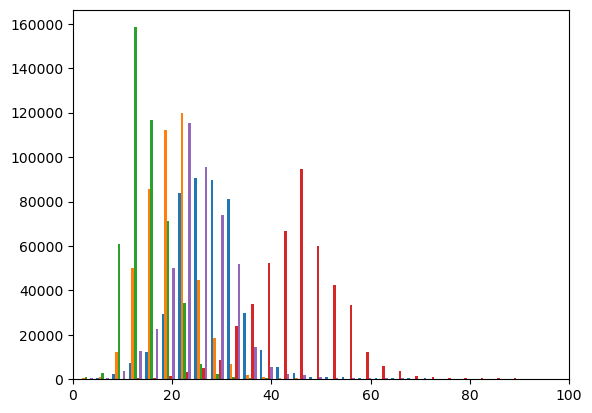

In [342]:
plt.hist(df[["bre_dp", "eg_dp", "er_dp", "es_dp", "or_dp"]], bins=1000)
plt.xlim([0, 100])
plt.show()

In [351]:
#filter based on coverage (calculated at 9x from above) in all 5 populations

cov_conditions = (df[["bre_dp", "eg_dp", "er_dp", "es_dp", "or_dp"]] >=10)
pass_df = df[cov_conditions.sum(axis=1) >= 5].reset_index(drop=True)

pass_df

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,78017,Sniffles2.DEL.76M0,GATCAATGGAACACTAGTTTATTAAATAAGTTGAGATTACAAACTG...,N,60,GT,PRECISE;SVTYPE=DEL;SVLEN=-283;END=78300;SUPPOR...,"smbre:0/0:60:31:1:Sniffles2.DEL.6018S0,Sniffle...",smeg:0/0:0:16:0:NULL,...,78300.0,1,"f6f34603-3a3d-4ce7-8e3a-60f8bcb187c7,43946f72-...","28,30,32,33,33",+-,0,120.915,135.765,10000,PRECISE
1,SM_V10_1,78660,Sniffles2.INS.2DM0,N,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGT...,60,GT,PRECISE;SVTYPE=INS;SVLEN=227;END=78660;SUPPORT...,smbre:0/0:0:33:0:NULL,smeg:0/0:40:18:1:Sniffles2.INS.21S0,...,78660.0,1,80f2fd1f-77e5-4075-9530-c4936ebc6f78,"17,18,19,20,21",-,0,0.000,0.000,1000,PRECISE
2,SM_V10_1,79182,Sniffles2.INV.90M0,N,<INV>,43,GT,PRECISE;SVTYPE=INV;SVLEN=391;END=79573;SUPPORT...,smbre:0/0:0:34:0:NULL,smeg:0/0:0:21:0:NULL,...,79573.0,1,4a08a6af-6d48-493f-b234-03d1b7fa93b4,"24,25,24,25,28",+,0,0.000,0.000,1,PRECISE
3,SM_V10_1,79697,Sniffles2.INS.2EM0,N,GGGGAGGAGGAGGAGAGAGGAGAAGTAATGAGGGAGGAGGAGAGAT...,60,GT,PRECISE;SVTYPE=INS;SVLEN=50;END=79697;SUPPORT=...,smbre:0/0:0:35:0:NULL,smeg:0/0:0:21:0:NULL,...,79697.0,1,78d5849f-a7ba-4a96-b770-89b580028146,"25,25,25,26,28",+,0,0.000,0.000,1,PRECISE
4,SM_V10_1,79814,Sniffles2.INV.91M0,N,<INV>,60,GT,PRECISE;SVTYPE=INV;SVLEN=76709629;END=76789443...,smbre:0/0:0:35:0:NULL,smeg:0/0:0:21:0:NULL,...,76789443.0,1,b7542c0d-ad65-401a-9a8e-0358223afbcd,"14,17,15,15,17",+,0,0.000,0.000,100,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413634,SM_V10_MITO,26821,Sniffles2.BND.2F8M9,N,]SM_V10_Z:50432427]N,41,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=4fe4740c-3...,smbre:0/0:0:1030:0:NULL,smeg:0/0:0:656:0:NULL,...,NaN,1,4fe4740c-349a-4784-95a3-fde6dc8414c3,"835,463,.,.,.",-,0,0.000,0.000,10,PRECISE
413635,SM_V10_MITO,26833,Sniffles2.BND.2F5M9,N,N]SM_V10_1:614204],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=c1afc27c-d...,smbre:0/0:60:709:1:Sniffles2.BND.D3S9,smeg:0/0:0:656:0:NULL,...,NaN,1,c1afc27c-def9-4178-a7ee-cbcfa68ebec2,"1033,710,.,.,.",+,0,0.000,0.000,10000,PRECISE
413636,SM_V10_MITO,26879,Sniffles2.BND.2F7M9,N,N]SM_V10_1:80890903],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=20923063-6...,smbre:0/0:0:1030:0:NULL,smeg:0/0:60:301:1:Sniffles2.BND.A5S9,...,NaN,1,20923063-667c-4eec-9e5b-04566e2f1860,"663,302,.,.,.",+,0,0.000,0.000,1000,PRECISE
413637,SM_V10_MITO,26901,Sniffles2.BND.2FAM9,N,N]SM_V10_3:49369998],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=68c4ac29-f...,smbre:0/0:60:709:1:Sniffles2.BND.D6S9,smeg:0/0:0:656:0:NULL,...,NaN,1,68c4ac29-fc6a-403f-b035-d8be4d37dbe9,"1012,710,.,.,.",+,0,0.000,0.000,10000,PRECISE


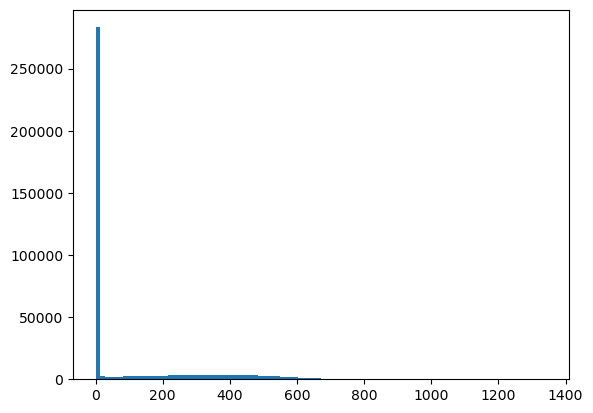

In [352]:
plt.hist(pass_df["STDEV_POS"], bins=100)
plt.show()

In [356]:
#filter out sites with GT or weird nonPass filters

pass_df = pass_df.loc[pass_df["STDEV_POS"] == 0  ]
pass_df=pass_df.reset_index(drop=True)
pass_df

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,78660,Sniffles2.INS.2DM0,N,GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGT...,60,GT,PRECISE;SVTYPE=INS;SVLEN=227;END=78660;SUPPORT...,smbre:0/0:0:33:0:NULL,smeg:0/0:40:18:1:Sniffles2.INS.21S0,...,78660.0,1,80f2fd1f-77e5-4075-9530-c4936ebc6f78,"17,18,19,20,21",-,0,0.0,0.0,1000,PRECISE
1,SM_V10_1,79182,Sniffles2.INV.90M0,N,<INV>,43,GT,PRECISE;SVTYPE=INV;SVLEN=391;END=79573;SUPPORT...,smbre:0/0:0:34:0:NULL,smeg:0/0:0:21:0:NULL,...,79573.0,1,4a08a6af-6d48-493f-b234-03d1b7fa93b4,"24,25,24,25,28",+,0,0.0,0.0,1,PRECISE
2,SM_V10_1,79697,Sniffles2.INS.2EM0,N,GGGGAGGAGGAGGAGAGAGGAGAAGTAATGAGGGAGGAGGAGAGAT...,60,GT,PRECISE;SVTYPE=INS;SVLEN=50;END=79697;SUPPORT=...,smbre:0/0:0:35:0:NULL,smeg:0/0:0:21:0:NULL,...,79697.0,1,78d5849f-a7ba-4a96-b770-89b580028146,"25,25,25,26,28",+,0,0.0,0.0,1,PRECISE
3,SM_V10_1,79814,Sniffles2.INV.91M0,N,<INV>,60,GT,PRECISE;SVTYPE=INV;SVLEN=76709629;END=76789443...,smbre:0/0:0:35:0:NULL,smeg:0/0:0:21:0:NULL,...,76789443.0,1,b7542c0d-ad65-401a-9a8e-0358223afbcd,"14,17,15,15,17",+,0,0.0,0.0,100,PRECISE
4,SM_V10_1,82947,Sniffles2.DUP.113M0,N,<DUP>,60,GT,PRECISE;SVTYPE=DUP;SVLEN=189271;END=272218;SUP...,smbre:0/0:0:39:0:NULL,smeg:0/0:0:31:0:NULL,...,272218.0,1,30563a94-b800-4c73-b1f8-776a6f0c5f82,"21,21,2,49,50",-,0,0.0,0.0,100,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276512,SM_V10_MITO,26821,Sniffles2.BND.2F8M9,N,]SM_V10_Z:50432427]N,41,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=4fe4740c-3...,smbre:0/0:0:1030:0:NULL,smeg:0/0:0:656:0:NULL,...,NaN,1,4fe4740c-349a-4784-95a3-fde6dc8414c3,"835,463,.,.,.",-,0,0.0,0.0,10,PRECISE
276513,SM_V10_MITO,26833,Sniffles2.BND.2F5M9,N,N]SM_V10_1:614204],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=c1afc27c-d...,smbre:0/0:60:709:1:Sniffles2.BND.D3S9,smeg:0/0:0:656:0:NULL,...,NaN,1,c1afc27c-def9-4178-a7ee-cbcfa68ebec2,"1033,710,.,.,.",+,0,0.0,0.0,10000,PRECISE
276514,SM_V10_MITO,26879,Sniffles2.BND.2F7M9,N,N]SM_V10_1:80890903],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=20923063-6...,smbre:0/0:0:1030:0:NULL,smeg:0/0:60:301:1:Sniffles2.BND.A5S9,...,NaN,1,20923063-667c-4eec-9e5b-04566e2f1860,"663,302,.,.,.",+,0,0.0,0.0,1000,PRECISE
276515,SM_V10_MITO,26901,Sniffles2.BND.2FAM9,N,N]SM_V10_3:49369998],60,GT,PRECISE;SVTYPE=BND;SUPPORT=1;RNAMES=68c4ac29-f...,smbre:0/0:60:709:1:Sniffles2.BND.D6S9,smeg:0/0:0:656:0:NULL,...,NaN,1,68c4ac29-fc6a-403f-b035-d8be4d37dbe9,"1012,710,.,.,.",+,0,0.0,0.0,10000,PRECISE


In [357]:
#filter out sites with GT or weird nonPass filters

pass_df = pass_df.loc[pass_df["filter"] == "PASS"]
pass_df=pass_df.reset_index(drop=True)
pass_df

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,248073,Sniffles2.INS.154M0,N,TTGGAATTGATTGAAAAACACCCATTGACTTGCTCATGTTTATCAA...,51,PASS,PRECISE;SVTYPE=INS;SVLEN=10117;END=248073;SUPP...,smbre:0/0:0:20:0:NULL,smeg:0/0:0:11:0:NULL,...,248073.0,1,da87f22b-37bf-443a-bd6c-2955ecb67c9c,"11,11,11,11,11",-,1,0.000,0.0,1,PRECISE
1,SM_V10_1,248654,Sniffles2.DEL.1A6M0,GAACAACATATATAAGCGAACAATATTGTTTTCAATTAGATCGTCA...,N,59,PASS,PRECISE;SVTYPE=DEL;SVLEN=-799;END=249453;SUPPO...,smbre:0/1:7:26:8:Sniffles2.DEL.6074S0,smeg:0/0:20:11:1:Sniffles2.DEL.5289S0,...,249453.0,4,"7aca350c-a84e-4ece-a74c-eb0797336909,df7146cf-...","14,22,24,24,26",+-,1,0.000,0.0,11000,PRECISE
2,SM_V10_1,317754,Sniffles2.INS.231M0,N,TTGGTGGAGTGACATCTATAGGAAGGTCTGTGTGGGCTGCTTCGAT...,56,PASS,PRECISE;SVTYPE=INS;SVLEN=1571;END=317754;SUPPO...,smbre:0/1:60:20:14:Sniffles2.INS.87S0,smeg:0/1:17:35:8:Sniffles2.INS.8AS0,...,317754.0,11,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","48,38,38,38,43",+-,2,2.121,0.0,11000,PRECISE
3,SM_V10_1,320651,Sniffles2.DEL.268M0,N,<DEL>,51,PASS,PRECISE;SVTYPE=DEL;SVLEN=-86164;END=406815;SUP...,smbre:0/1:49:11:8:Sniffles2.DEL.60B3S0,smeg:0/1:0:31:0:NULL,...,406815.0,8,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","37,24,9,25,47",+-,1,0.000,0.0,10000,PRECISE
4,SM_V10_1,492198,Sniffles2.DEL.338M0,GCAACGTCTCTGACTGTGAAGCTGAGTGACGCGGGATCGAATCCGC...,N,54,PASS,PRECISE;SVTYPE=DEL;SVLEN=-2232;END=494430;SUPP...,smbre:0/1:0:23:0:NULL,smeg:0/1:60:32:16:Sniffles2.DEL.5338S0,...,494430.0,16,"7ddf4592-af15-4935-b91f-41248ad5cc48,f6d66cb7-...","46,45,47,53,51",+-,1,0.000,0.0,1000,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,SM_V10_MITO,21803,Sniffles2.DEL.3EM9,TAGTATTATCGTCTATAGTCCCTTGGTTTCTTAGTGTTATAGCCCA...,N,52,PASS,IMPRECISE;SVTYPE=DEL;SVLEN=-989;END=22792;SUPP...,smbre:1/1:0:1940:0:NULL,smeg:1/1:0:1476:0:NULL,...,22792.0,962,"fd7299cc-6c77-4620-b9ef-408c399e5df2,50b5d748-...","1080,1027,1109,1250,1234",+-,2,0.000,0.0,10,IMPRECISE
3177,SM_V10_MITO,22071,Sniffles2.INS.19M9,N,AGTGATCAAGGTAAAATTAAAGAAAATGTTGTTTGTTTGATTCTGT...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=15872;END=22071;SUPPO...,smbre:0/1:57:1340:417:Sniffles2.INS.6S9,smeg:0/1:0:1401:0:NULL,...,22071.0,56,7ebd6cc5-7771-4221-b54b-2491894b7ff7,"1825,1746,1757,1767,1764",+,1,0.000,0.0,10000,PRECISE
3178,SM_V10_MITO,24358,Sniffles2.INS.2E3M9,N,GGTAGGTGGGTAAGGTAGAAAATGTTCTTGTTTGATTCTGTAT,58,PASS,IMPRECISE;SVTYPE=INS;SVLEN=61;END=24358;SUPPOR...,smbre:0/1:0:1466:0:NULL,smeg:0/1:0:1405:0:NULL,...,24358.0,127,"3c480c91-92bf-4da2-adb1-dd89f9001840,96d16e2e-...","595,498,486,481,510",+-,1,0.000,0.0,100,IMPRECISE
3179,SM_V10_MITO,25330,Sniffles2.DEL.2E5M9,TTTAGTATTATCGTCTATAGTCCCTTGGTTTCTTAGTGTTATAGCC...,N,55,PASS,IMPRECISE;SVTYPE=DEL;SVLEN=-123;END=25453;SUPP...,smbre:1/1:60:101:1220:Sniffles2.DEL.2FS9,smeg:1/1:0:1138:0:NULL,...,25453.0,1220,"6ec5e999-cf4d-4b8e-ab9a-6356d8aaffb9,b238f1bd-...","1287,1313,1315,1335,1159",+-,2,0.000,0.0,10000,IMPRECISE


In [358]:
pass_df = pass_df.loc[pass_df["BPOINT"] == "PRECISE"]
pass_df=pass_df.reset_index(drop=True)
pass_df

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,248073,Sniffles2.INS.154M0,N,TTGGAATTGATTGAAAAACACCCATTGACTTGCTCATGTTTATCAA...,51,PASS,PRECISE;SVTYPE=INS;SVLEN=10117;END=248073;SUPP...,smbre:0/0:0:20:0:NULL,smeg:0/0:0:11:0:NULL,...,248073.0,1,da87f22b-37bf-443a-bd6c-2955ecb67c9c,"11,11,11,11,11",-,1,0.000,0.0,1,PRECISE
1,SM_V10_1,248654,Sniffles2.DEL.1A6M0,GAACAACATATATAAGCGAACAATATTGTTTTCAATTAGATCGTCA...,N,59,PASS,PRECISE;SVTYPE=DEL;SVLEN=-799;END=249453;SUPPO...,smbre:0/1:7:26:8:Sniffles2.DEL.6074S0,smeg:0/0:20:11:1:Sniffles2.DEL.5289S0,...,249453.0,4,"7aca350c-a84e-4ece-a74c-eb0797336909,df7146cf-...","14,22,24,24,26",+-,1,0.000,0.0,11000,PRECISE
2,SM_V10_1,317754,Sniffles2.INS.231M0,N,TTGGTGGAGTGACATCTATAGGAAGGTCTGTGTGGGCTGCTTCGAT...,56,PASS,PRECISE;SVTYPE=INS;SVLEN=1571;END=317754;SUPPO...,smbre:0/1:60:20:14:Sniffles2.INS.87S0,smeg:0/1:17:35:8:Sniffles2.INS.8AS0,...,317754.0,11,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","48,38,38,38,43",+-,2,2.121,0.0,11000,PRECISE
3,SM_V10_1,320651,Sniffles2.DEL.268M0,N,<DEL>,51,PASS,PRECISE;SVTYPE=DEL;SVLEN=-86164;END=406815;SUP...,smbre:0/1:49:11:8:Sniffles2.DEL.60B3S0,smeg:0/1:0:31:0:NULL,...,406815.0,8,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","37,24,9,25,47",+-,1,0.000,0.0,10000,PRECISE
4,SM_V10_1,492198,Sniffles2.DEL.338M0,GCAACGTCTCTGACTGTGAAGCTGAGTGACGCGGGATCGAATCCGC...,N,54,PASS,PRECISE;SVTYPE=DEL;SVLEN=-2232;END=494430;SUPP...,smbre:0/1:0:23:0:NULL,smeg:0/1:60:32:16:Sniffles2.DEL.5338S0,...,494430.0,16,"7ddf4592-af15-4935-b91f-41248ad5cc48,f6d66cb7-...","46,45,47,53,51",+-,1,0.000,0.0,1000,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,SM_V10_WSR,5422298,Sniffles2.DUP.1180M8,N,<DUP>,47,PASS,PRECISE;SVTYPE=DUP;SVLEN=10543;END=5432841;SUP...,smbre:0/0:60:371:34:Sniffles2.DUP.FA2S8,smeg:0/0:60:179:15:Sniffles2.DUP.A42S8,...,5432841.0,37,"05372f01-b670-45e0-869a-370a882b790d,5a71ed9b-...","1,1,0,330,310",+-,1,0.000,0.0,11111,PRECISE
2811,SM_V10_WSR,5431769,Sniffles2.INS.1138M8,N,GCAGTCATCCGTCCGTCTTCCGTCGTCGTCGTCGTCACTTGGAGTA...,39,PASS,PRECISE;SVTYPE=INS;SVLEN=6769;END=5431769;SUPP...,smbre:0/1:60:30:77:Sniffles2.INS.7DES8,smeg:0/1:0:35:0:NULL,...,5431769.0,15,3419fb26-2800-43c3-b7da-8242f625e414,"61,107,107,107,739",+,1,0.000,0.0,10000,PRECISE
2812,SM_V10_WSR,5433621,Sniffles2.INS.1137M8,N,CATCATCCAAAGTCAACATCATCATCATTATCATCATTTCGGGCCG...,21,PASS,PRECISE;SVTYPE=INS;SVLEN=7417;END=5433621;SUPP...,smbre:0/1:0:364:0:NULL,smeg:0/1:60:74:87:Sniffles2.INS.4F8S8,...,5433621.0,17,6316accd-4209-4ed5-9f3d-07a79f3fa1a2,"174,164,161,156,143",+,1,0.000,0.0,1000,PRECISE
2813,SM_V10_MITO,13700,Sniffles2.INS.10M9,N,GGTACCCAGTAGGTGGGTAGGTAGAAACCAAGGGACTACAGGCATG...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=5347;END=13700;SUPPOR...,smbre:0/1:0:2665:0:NULL,smeg:0/1:60:1675:617:Sniffles2.INS.4S9,...,13700.0,131,c372635a-0632-4e3b-b694-9bdd994ae677,"2285,2298,2292,2288,2242",+,1,0.000,0.0,1000,PRECISE


In [359]:
duplicates = pass_df[pass_df[["chrom", "pos"]].duplicated(subset=["chrom", "pos"], keep=False)]
duplicates

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
144,SM_V10_1,24074861,Sniffles2.INS.8666M0,N,TTCTCTGTTAGGTCGGCTTACAATAAACTCTAGAGGCTCATAAAGA...,54,PASS,PRECISE;SVTYPE=INS;SVLEN=2901;END=24074861;SUP...,smbre:1/1:0:30:0:NULL,smeg:1/1:0:21:0:NULL,...,24074861.0,9,"5e7b7691-4fc8-4299-b047-e138d4b613ba,47b63da3-...","23,8,8,8,18",+-,2,0.000,0.0,1,PRECISE
145,SM_V10_1,24074861,Sniffles2.BND.86D5M0,N,N[SM_V10_Z:8889795[,60,PASS,PRECISE;SVTYPE=BND;SUPPORT=4;RNAMES=0c7cd3df-a...,smbre:0/0:0:30:0:NULL,smeg:0/0:0:21:0:NULL,...,NaN,4,"0c7cd3df-a6b1-44de-b67c-6e4df208a8c7,947d75bf-...","23,8,18,17,17",+-,1,0.000,0.0,1,PRECISE
244,SM_V10_1,40298754,Sniffles2.INS.DD81M0,N,CCTAATGTTAGGATATTACGAATATCCCAAGAAGTACTCTCGAATG...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=427;END=40298754;SUPP...,smbre:0/1:42:9:17:Sniffles2.INS.2C13S0,smeg:0/0:34:16:1:Sniffles2.INS.2614S0,...,40298754.0,6,"ca0f4623-5cf0-4175-a303-7aef6148a2e1,3981d68b-...","21,21,26,25,26",+-,2,3.512,0.0,11110,PRECISE
245,SM_V10_1,40298754,Sniffles2.INS.DD82M0,N,CCTAATGTTAGGATATTCCACAAGAATATCCCAAAATTATCTCGAA...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=2794;END=40298754;SUP...,smbre:0/1:55:10:16:Sniffles2.INS.2C14S0,smeg:0/1:0:16:0:NULL,...,40298754.0,7,"9018cd47-6a82-497f-acba-044d6f5a34d8,c3b72588-...","12,14,22,21,26",+-,2,5.657,0.0,10001,PRECISE
412,SM_V10_1,69460571,Sniffles2.BND.17492M0,N,N[SM_V10_2:4095544[,60,PASS,PRECISE;SVTYPE=BND;SUPPORT=2;RNAMES=afb5cfd6-e...,smbre:0/0:0:30:0:NULL,smeg:0/0:0:17:0:NULL,...,NaN,2,"afb5cfd6-e7a2-4d16-8f01-1cd1f9c8418d,f358fba5-...","25,11,10,10,9",+,1,0.000,0.0,110,PRECISE
413,SM_V10_1,69460571,Sniffles2.BND.17493M0,N,N[SM_V10_4:24015709[,60,PASS,PRECISE;SVTYPE=BND;SUPPORT=2;RNAMES=5cc548fa-1...,smbre:0/0:0:30:0:NULL,smeg:0/0:0:17:0:NULL,...,NaN,2,"5cc548fa-1be5-45d6-8d8a-9a945f053038,ebb31a40-...","25,11,10,10,10",+,1,0.000,0.0,111,PRECISE
721,SM_V10_Z,47615898,Sniffles2.INS.BD91M1,N,TTTTCCTTCCTTCAGCCACCGAAGCCCGCGACTTAGTTCAAAACAC...,58,PASS,PRECISE;SVTYPE=INS;SVLEN=2056;END=47615898;SUP...,smbre:1/1:0:18:0:NULL,smeg:1/1:0:17:0:NULL,...,47615898.0,25,"0e932b8b-1be1-4f80-ae72-c59b06343b5e,3104e86f-...","34,27,27,27,31",+-,2,0.000,0.0,1,PRECISE
722,SM_V10_Z,47615898,Sniffles2.INV.BDD5M1,N,<INV>,59,PASS,PRECISE;SVTYPE=INV;SVLEN=818;END=47616716;SUPP...,smbre:0/1:60:12:17:Sniffles2.INV.783CS1,smeg:0/1:60:13:11:Sniffles2.INV.6438S1,...,47616716.0,14,"4abe57b4-64e3-477f-8e68-a3be8f33e7ff,00baf5f5-...","25,12,12,11,25",+-,4,0.000,0.0,11110,PRECISE
894,SM_V10_Z,73742644,Sniffles2.INS.145D1M1,N,TTATTTTTTTTTTTATTTAAACACATATATATTGGTACAAAAGGGC...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=3881;END=73742644;SUP...,smbre:1/1:60:0:50:Sniffles2.INS.3FEES1,smeg:1/1:47:0:17:Sniffles2.INS.34CCS1,...,73742644.0,15,"35c30673-16f1-4ee9-bd88-8c7b25858117,b73042d6-...","27,15,15,15,26",+-,10,34.745,0.0,11111,PRECISE
895,SM_V10_Z,73742644,Sniffles2.BND.1463AM1,N,N[SM_V10_1:21051212[,60,PASS,PRECISE;SVTYPE=BND;SUPPORT=3;RNAMES=228d207a-5...,smbre:0/0:54:23:1:Sniffles2.BND.8E24S1,smeg:0/1:29:11:6:Sniffles2.BND.7102S1,...,NaN,3,"228d207a-56a9-4885-91ba-13e37c29d085,fdad02b4-...","27,15,26,27,26",+-,2,0.000,0.0,11111,PRECISE


In [360]:
pass_df = pass_df.drop(index=duplicates.index).reset_index(drop=True)
pass_df


,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,248073,Sniffles2.INS.154M0,N,TTGGAATTGATTGAAAAACACCCATTGACTTGCTCATGTTTATCAA...,51,PASS,PRECISE;SVTYPE=INS;SVLEN=10117;END=248073;SUPP...,smbre:0/0:0:20:0:NULL,smeg:0/0:0:11:0:NULL,...,248073.0,1,da87f22b-37bf-443a-bd6c-2955ecb67c9c,"11,11,11,11,11",-,1,0.000,0.0,1,PRECISE
1,SM_V10_1,248654,Sniffles2.DEL.1A6M0,GAACAACATATATAAGCGAACAATATTGTTTTCAATTAGATCGTCA...,N,59,PASS,PRECISE;SVTYPE=DEL;SVLEN=-799;END=249453;SUPPO...,smbre:0/1:7:26:8:Sniffles2.DEL.6074S0,smeg:0/0:20:11:1:Sniffles2.DEL.5289S0,...,249453.0,4,"7aca350c-a84e-4ece-a74c-eb0797336909,df7146cf-...","14,22,24,24,26",+-,1,0.000,0.0,11000,PRECISE
2,SM_V10_1,317754,Sniffles2.INS.231M0,N,TTGGTGGAGTGACATCTATAGGAAGGTCTGTGTGGGCTGCTTCGAT...,56,PASS,PRECISE;SVTYPE=INS;SVLEN=1571;END=317754;SUPPO...,smbre:0/1:60:20:14:Sniffles2.INS.87S0,smeg:0/1:17:35:8:Sniffles2.INS.8AS0,...,317754.0,11,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","48,38,38,38,43",+-,2,2.121,0.0,11000,PRECISE
3,SM_V10_1,320651,Sniffles2.DEL.268M0,N,<DEL>,51,PASS,PRECISE;SVTYPE=DEL;SVLEN=-86164;END=406815;SUP...,smbre:0/1:49:11:8:Sniffles2.DEL.60B3S0,smeg:0/1:0:31:0:NULL,...,406815.0,8,"0ce592c6-7511-41fb-982f-0041f90b8276,7f7af236-...","37,24,9,25,47",+-,1,0.000,0.0,10000,PRECISE
4,SM_V10_1,492198,Sniffles2.DEL.338M0,GCAACGTCTCTGACTGTGAAGCTGAGTGACGCGGGATCGAATCCGC...,N,54,PASS,PRECISE;SVTYPE=DEL;SVLEN=-2232;END=494430;SUPP...,smbre:0/1:0:23:0:NULL,smeg:0/1:60:32:16:Sniffles2.DEL.5338S0,...,494430.0,16,"7ddf4592-af15-4935-b91f-41248ad5cc48,f6d66cb7-...","46,45,47,53,51",+-,1,0.000,0.0,1000,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,SM_V10_WSR,5422298,Sniffles2.DUP.1180M8,N,<DUP>,47,PASS,PRECISE;SVTYPE=DUP;SVLEN=10543;END=5432841;SUP...,smbre:0/0:60:371:34:Sniffles2.DUP.FA2S8,smeg:0/0:60:179:15:Sniffles2.DUP.A42S8,...,5432841.0,37,"05372f01-b670-45e0-869a-370a882b790d,5a71ed9b-...","1,1,0,330,310",+-,1,0.000,0.0,11111,PRECISE
2773,SM_V10_WSR,5431769,Sniffles2.INS.1138M8,N,GCAGTCATCCGTCCGTCTTCCGTCGTCGTCGTCGTCACTTGGAGTA...,39,PASS,PRECISE;SVTYPE=INS;SVLEN=6769;END=5431769;SUPP...,smbre:0/1:60:30:77:Sniffles2.INS.7DES8,smeg:0/1:0:35:0:NULL,...,5431769.0,15,3419fb26-2800-43c3-b7da-8242f625e414,"61,107,107,107,739",+,1,0.000,0.0,10000,PRECISE
2774,SM_V10_WSR,5433621,Sniffles2.INS.1137M8,N,CATCATCCAAAGTCAACATCATCATCATTATCATCATTTCGGGCCG...,21,PASS,PRECISE;SVTYPE=INS;SVLEN=7417;END=5433621;SUPP...,smbre:0/1:0:364:0:NULL,smeg:0/1:60:74:87:Sniffles2.INS.4F8S8,...,5433621.0,17,6316accd-4209-4ed5-9f3d-07a79f3fa1a2,"174,164,161,156,143",+,1,0.000,0.0,1000,PRECISE
2775,SM_V10_MITO,13700,Sniffles2.INS.10M9,N,GGTACCCAGTAGGTGGGTAGGTAGAAACCAAGGGACTACAGGCATG...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=5347;END=13700;SUPPOR...,smbre:0/1:0:2665:0:NULL,smeg:0/1:60:1675:617:Sniffles2.INS.4S9,...,13700.0,131,c372635a-0632-4e3b-b694-9bdd994ae677,"2285,2298,2292,2288,2242",+,1,0.000,0.0,1000,PRECISE


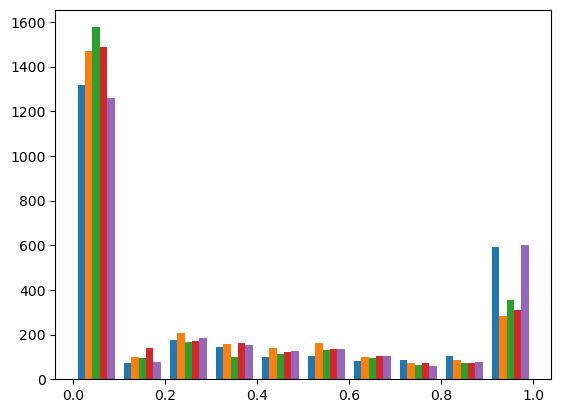

In [361]:
plt.hist(pass_df[["bre_af", "eg_af", "er_af", "es_af", "or_af"]])
plt.show()

In [363]:
#shared SVs are present at >50% in 4 of 5 populations

af_cols = ["bre_af", "eg_af", "er_af", "es_af", "or_af"]


shared_conditions = (pass_df[af_cols] > 0.5)
fixed_conditions = (pass_df[af_cols] >=0.99)

shared_idx = pass_df[shared_conditions.sum(axis=1) >= 5].index
fixed_idx  = pass_df[fixed_conditions.sum(axis=1) >= 1].index


idxs=list(set(list(shared_idx) + list(fixed_idx)))
idxs.sort()

selected_svs_df = pass_df.iloc[idxs].reset_index(drop=True)

selected_svs_df = selected_svs_df[~selected_svs_df[af_cols].isin(['.']).any(axis=1)].reset_index(drop=True)
selected_svs_df.to_csv("selected_svs.tsv", sep="\t", header=True, index=False)
selected_svs_df

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
0,SM_V10_1,996897,Sniffles2.DEL.68CM0,TTCCGGTGAATTGTATGAAAACAAAGTTGATTGACAATGAGAATTA...,N,48,PASS,PRECISE;SVTYPE=DEL;SVLEN=-243;END=997140;SUPPO...,smbre:0/1:9:6:18:Sniffles2.DEL.6180S0,smeg:0/1:19:5:25:Sniffles2.DEL.53FFS0,...,997140.0,23,"3e895c53-8f76-4617-a3fd-b4727f620dc8,037c7869-...","31,30,31,31,32",+-,5,0.000,0.0,11111,PRECISE
1,SM_V10_1,1379140,Sniffles2.INS.89AM0,N,CATGATTATGATGATGTTTACAATGAAGAGCAATGATCATGATGAT...,29,PASS,PRECISE;SVTYPE=INS;SVLEN=2763;END=1379140;SUPP...,smbre:1/1:0:16:0:NULL,smeg:1/1:0:10:0:NULL,...,1379140.0,10,99ec4990-f796-40e6-90d4-a3df68885b13,"20,21,21,113,161",-,2,0.000,0.0,1,PRECISE
2,SM_V10_1,1569376,Sniffles2.DEL.9D1M0,TGCTTGTTGATCATTGGTCACTTTCAAAACTCAGAGCATTGTAAAT...,N,59,PASS,PRECISE;SVTYPE=DEL;SVLEN=-1269;END=1570645;SUP...,smbre:1/1:58:0:21:Sniffles2.DEL.621FS0,smeg:0/1:40:6:7:Sniffles2.DEL.54A2S0,...,1570645.0,18,"69dc82f0-5ea9-4fc7-8c5d-e522a2d6991a,7ae1c101-...","22,20,20,19,21",+-,9,0.000,0.0,11111,PRECISE
3,SM_V10_1,2059168,Sniffles2.DEL.CFBM0,AAACTGATTATAATCAGAAGGGGTTTTGTGGAGATTTTAGTATTTT...,N,60,PASS,PRECISE;SVTYPE=DEL;SVLEN=-348;END=2059516;SUPP...,smbre:1/1:60:0:29:Sniffles2.DEL.62FFS0,smeg:1/1:50:0:18:Sniffles2.DEL.5538S0,...,2059516.0,30,"ca3bed47-ce12-5fe4-adcb-e378cec062f3,f93b12ab-...","30,29,30,29,30",+-,10,0.000,0.0,11111,PRECISE
4,SM_V10_1,2259854,Sniffles2.INS.DE6M0,N,CTACTGTTGTGAATGAGAACACAGGTGAGGACAACCAACTATGTAT...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=4390;END=2259854;SUPP...,smbre:1/1:10:2:11:Sniffles2.INS.33CS0,smeg:0/1:20:4:7:Sniffles2.INS.2CBS0,...,2259854.0,10,"f244b580-8ce9-41f1-86c6-89a715c7be1c,9055bd6d-...","24,14,14,14,21",+-,9,51.949,0.0,11111,PRECISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,SM_V10_7,18179333,Sniffles2.INS.5BCBM7,N,AGTTTCAGTTTCAGTTTGGAAAGGACAGGAGGAGCTTGATGGCCTG...,57,PASS,PRECISE;SVTYPE=INS;SVLEN=3679;END=18179333;SUP...,smbre:1/1:60:0:36:Sniffles2.INS.13AFS7,smeg:1/1:60:0:24:Sniffles2.INS.1092S7,...,18179333.0,12,"ae768530-a8b6-414b-8138-4169d6a4824a,eba81220-...","22,13,13,13,24",+-,10,34.926,0.0,11111,PRECISE
845,SM_V10_7,18386836,Sniffles2.DEL.5D23M7,GAACTCGGAATTCGGGTACCAGATCGTGATTGGAATAAGGCAGGTA...,N,60,PASS,PRECISE;SVTYPE=DEL;SVLEN=-102;END=18386938;SUP...,smbre:1/1:56:1:24:Sniffles2.DEL.1E02S7,smeg:1/1:60:0:25:Sniffles2.DEL.1A58S7,...,18386938.0,24,"af5323ae-2ef8-4ee0-a703-85ff4c73eceb,6321c771-...","27,28,28,28,28",+-,9,0.000,0.0,11111,PRECISE
846,SM_V10_7,18524568,Sniffles2.INS.5DE6M7,N,TAGATCAGAAGGGTTTTGTGGATATTTCAGTATTTTTCGTTAGAAA...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=597;END=18524568;SUPP...,smbre:1/1:60:0:24:Sniffles2.INS.1429S7,smeg:0/1:60:12:13:Sniffles2.INS.1115S7,...,18524568.0,18,"bcf8c236-b0ad-4acd-a7a2-3c34a587fcc0,8c2e53ca-...","20,23,23,22,29",+-,8,7.603,0.0,11111,PRECISE
847,SM_V10_7,18983721,Sniffles2.DEL.606AM7,TAAACAAGATTTTCCATGGTGGTCTAGCTTCAATTGACTCACGCTT...,N,60,PASS,PRECISE;SVTYPE=DEL;SVLEN=-56;END=18983777;SUPP...,smbre:1/1:1:6:21:Sniffles2.DEL.1EC0S7,smeg:1/1:9:4:11:Sniffles2.DEL.1ADAS7,...,18983777.0,15,"dacb7421-992e-47d0-9565-05a971a7e5c8,67a3df7b-...","25,25,25,25,25",+-,8,0.000,0.0,11111,PRECISE


In [364]:
selected_svs_df.columns


Index(['chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'bre',
       'eg', 'er', 'es', 'or', 'bre_gt', 'bre_gq', 'bre_dr', 'bre_dv',
       'bre_id', 'eg_gt', 'eg_gq', 'eg_dr', 'eg_dv', 'eg_id', 'er_gt', 'er_gq',
       'er_dr', 'er_dv', 'er_id', 'es_gt', 'es_gq', 'es_dr', 'es_dv', 'es_id',
       'or_gt', 'or_gq', 'or_dr', 'or_dv', 'or_id', 'bre_dp', 'bre_af',
       'eg_dp', 'eg_af', 'er_dp', 'er_af', 'es_dp', 'es_af', 'or_dp', 'or_af',
       'SVTYPE', 'SVLEN', 'END', 'SUPPORT', 'RNAMES', 'COVERAGE', 'STRAND',
       'AC', 'STDEV_LEN', 'STDEV_POS', 'SUPP_VEC', 'BPOINT'],
      dtype='object')

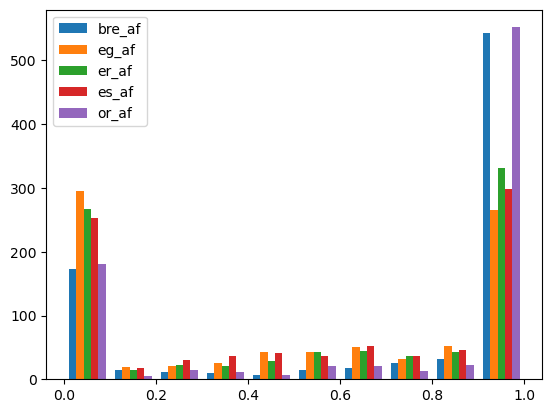

In [365]:
plt.hist(selected_svs_df[af_cols], label = af_cols)
plt.legend()
plt.show()

In [366]:
selected_svs_df["SVTYPE"].value_counts()

SVTYPE
DEL    429
INS    406
INV     12
BND      2
Name: count, dtype: int64

In [367]:
selected_svs_df.groupby("SVTYPE")["SVLEN"].median()

SVTYPE
BND       NaN
DEL   -1001.0
INS    2665.5
INV     368.0
Name: SVLEN, dtype: float64

In [368]:
selected_svs_df.groupby("SVTYPE")["SVLEN"].max()

SVTYPE
BND        NaN
DEL      -45.0
INS    16171.0
INV      860.0
Name: SVLEN, dtype: float64

In [369]:
selected_svs_df.loc[selected_svs_df["SVTYPE"] == "INV"]

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT
33,SM_V10_1,19617990,Sniffles2.INV.6EA0M0,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=305;END=19618295;SUPP...,smbre:0/1:20:9:25:Sniffles2.INV.8E0AS0,smeg:0/1:60:17:26:Sniffles2.INV.7B71S0,...,19618295.0,26,"c5d99eff-e4b8-4c0c-9c57-3ee704dc38c0,a410422b-...","27,0,0,0,26",+-,5,0.000,0.0,11111,PRECISE
41,SM_V10_1,22602535,Sniffles2.INV.7EEBM0,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=326;END=22602861;SUPP...,smbre:0/1:60:12:20:Sniffles2.INV.8EE0S0,smeg:0/1:60:13:23:Sniffles2.INV.7BFAS0,...,22602861.0,19,"f796f856-7ae3-45a8-a664-a03c7410aa98,f81e96fa-...","28,2,2,2,25",+-,5,37.559,0.0,11111,PRECISE
121,SM_V10_1,66773710,Sniffles2.INV.16694M0,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=327;END=66774037;SUPP...,smbre:0/1:40:11:25:Sniffles2.INV.9BBDS0,smeg:0/1:50:9:14:Sniffles2.INV.8575S0,...,66774037.0,23,"30415204-0ea9-49ca-bf50-6fc3f399a112,82e6e0e0-...","23,1,1,1,24",+-,5,0.000,0.0,11111,PRECISE
190,SM_V10_Z,3754207,Sniffles2.INV.15EFM1,N,<INV>,59,PASS,PRECISE;SVTYPE=INV;SVLEN=348;END=3754555;SUPPO...,smbre:0/1:42:9:17:Sniffles2.INV.7076S1,smeg:0/1:55:10:16:Sniffles2.INV.5F64S1,...,3754555.0,18,"6f81e71a-89ad-4118-8550-ce73c7f6a86a,acd0c458-...","24,6,6,4,12",+-,5,1.949,0.0,11111,PRECISE
212,SM_V10_Z,16117926,Sniffles2.INV.4EEFM1,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=371;END=16118297;SUPP...,smbre:0/1:23:4:6:Sniffles2.INV.7340S1,smeg:0/1:30:5:7:Sniffles2.INV.60F9S1,...,16118297.0,13,"f1220dfa-e05e-4238-ae2c-c2c88540e3b4,9fe76383-...","13,0,0,0,12",+-,5,0.000,0.0,11111,PRECISE
216,SM_V10_Z,40114450,Sniffles2.INV.9C8DM1,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=844;END=40115294;SUPP...,smbre:0/1:42:7:10:Sniffles2.INV.7694S1,smeg:0/1:17:4:8:Sniffles2.INV.6303S1,...,40115294.0,13,"34865f58-8cab-49c2-962b-f7a5c5b9623c,8c1484e2-...","14,1,1,1,15",+-,5,0.000,0.0,11111,PRECISE
298,SM_V10_Z,82870094,Sniffles2.INV.1741DM1,N,<INV>,59,PASS,PRECISE;SVTYPE=INV;SVLEN=365;END=82870459;SUPP...,smbre:0/1:58:15:33:Sniffles2.INV.81EES1,smeg:0/1:37:11:26:Sniffles2.INV.6B48S1,...,82870459.0,25,"4fae4c93-28d3-4908-8bdd-f89a5452905b,d58f9c4b-...","25,2,2,2,26",+-,5,0.000,0.0,11111,PRECISE
324,SM_V10_3,2505406,Sniffles2.INV.E6DM2,N,<INV>,59,PASS,PRECISE;SVTYPE=INV;SVLEN=860;END=2506266;SUPPO...,smbre:0/1:60:15:26:Sniffles2.INV.5A14S2,smeg:0/1:52:10:17:Sniffles2.INV.4C23S2,...,2506266.0,25,"f86680eb-62ef-4f14-a3f3-3a8b14a8c29e,d5e0a207-...","28,2,1,1,26",+-,5,0.000,0.0,11111,PRECISE
617,SM_V10_2,15081671,Sniffles2.INV.53D2M4,N,<INV>,60,PASS,PRECISE;SVTYPE=INV;SVLEN=295;END=15081966;SUPP...,smbre:0/1:60:12:19:Sniffles2.INV.5383S4,smeg:0/1:32:8:17:Sniffles2.INV.4917S4,...,15081966.0,21,"bf07bbd5-1022-4cc8-8d12-8480a7c71b22,84a484b3-...","21,0,0,0,20",+-,5,0.000,0.0,11111,PRECISE
619,SM_V10_2,15520758,Sniffles2.INV.5670M4,N,<INV>,59,PASS,PRECISE;SVTYPE=INV;SVLEN=463;END=15521221;SUPP...,smbre:0/1:48:14:33:Sniffles2.INV.53A3S4,smeg:0/1:40:11:25:Sniffles2.INV.4933S4,...,15521221.0,25,"f4cf7527-a60a-4d52-8199-a6ba3e0f1b84,f83cd226-...","26,0,0,0,23",+-,5,0.000,0.0,11111,PRECISE


In [370]:
selected_svs_df.groupby("SVTYPE")["SVLEN"].min()

SVTYPE
BND        NaN
DEL   -57107.0
INS       46.0
INV      295.0
Name: SVLEN, dtype: float64

In [371]:
selected_svs_df.loc[abs(selected_svs_df["SVLEN"]) > 1e6].sort_values(["SVLEN"])

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,END,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT


In [372]:
selected_svs_df.to_csv("selected_svs.tsv", sep="\t", header=True, index=False)

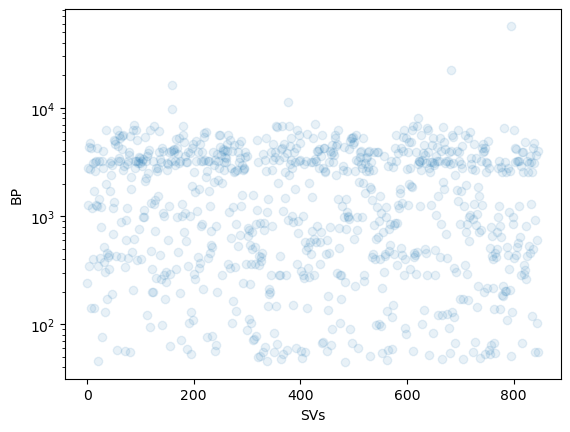

In [373]:
l=abs(selected_svs_df.loc[abs(selected_svs_df["SVLEN"])>0, "SVLEN"])
plt.scatter(range(0, len(l)), l, alpha=0.1)
plt.yscale('log')
plt.xlabel("SVs")
plt.ylabel("BP")
plt.show()

In [422]:
pop_specific_svs = delta_af_df.loc[delta_af_df["af_diff"] ==1].reset_index(drop=True)
pop_specific_svs.to_csv("pop_specific_svs.csv", sep=",", header=True, index=False)
pop_specific_svs

,chrom,pos,id,ref,alt,qual,filter,info,bre,eg,...,SUPPORT,RNAMES,COVERAGE,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT,af_diff
0,SM_V10_1,1379140,Sniffles2.INS.89AM0,N,CATGATTATGATGATGTTTACAATGAAGAGCAATGATCATGATGAT...,29,PASS,PRECISE;SVTYPE=INS;SVLEN=2763;END=1379140;SUPP...,smbre:1/1:0:16:0:NULL,smeg:1/1:0:10:0:NULL,...,10,99ec4990-f796-40e6-90d4-a3df68885b13,"20,21,21,113,161",-,2,0.0,0.0,1,PRECISE,1.0
1,SM_V10_1,14303059,Sniffles2.INS.50DDM0,N,GACTGTGATGTGTGGGCGAGAATGATAATGATTGGTTGTCTTGATG...,58,PASS,PRECISE;SVTYPE=INS;SVLEN=3223;END=14303059;SUP...,smbre:1/1:60:0:31:Sniffles2.INS.10FDS0,smeg:1/1:0:16:0:NULL,...,15,"142c2a1b-be69-48b6-9ce5-0bef95912a98,4ebcb326-...","30,29,29,28,36",+-,2,0.0,0.0,10000,PRECISE,1.0
2,SM_V10_1,14666099,Sniffles2.INS.528FM0,N,TGAGGTAACAGCTTCAGGCTATTAAGCAAGAGTTGACCTCAAACAA...,58,PASS,PRECISE;SVTYPE=INS;SVLEN=2801;END=14666099;SUP...,smbre:1/1:0:27:0:NULL,smeg:1/1:0:15:0:NULL,...,10,"b9bb4516-7508-4678-898b-b9f0d5d9a8dd,92155d45-...","28,18,18,18,26",+-,2,0.0,0.0,1,PRECISE,1.0
3,SM_V10_1,19701657,Sniffles2.INS.6EEBM0,N,GCACCACAATTTAAATGAATGTTGGGCTTCTTGTAATTACTCGTAC...,55,PASS,PRECISE;SVTYPE=INS;SVLEN=129;END=19701657;SUPP...,smbre:1/1:0:27:0:NULL,smeg:1/1:0:24:0:NULL,...,17,"ef07ba40-4344-470d-85a7-e7ae4b724509,b5865107-...","18,17,16,16,14",+-,2,0.0,0.0,1,PRECISE,1.0
4,SM_V10_1,19744018,Sniffles2.INS.6F07M0,N,AACTTGTAACAGCTCAGGTTGGTTGGACAAGTTGACCCCAAACAAT...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=6257;END=19744018;SUP...,smbre:1/1:0:32:0:NULL,smeg:1/1:0:25:0:NULL,...,9,"6e03b3e8-6b68-41ee-ad77-2a2152cbb7d5,12cd4522-...","21,10,10,10,25",+-,2,0.0,0.0,1,PRECISE,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,SM_V10_5,17972631,Sniffles2.INS.5FD7M6,N,GCACTTTCGTGCCTATAGGTAACCCTCGTGCTATTGATAGAAGAAA...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=6263;END=17972631;SUP...,smbre:1/1:0:27:0:NULL,smeg:1/1:0:25:0:NULL,...,9,"22e3264f-e2e1-488f-a21d-7411df50b369,172d9f0d-...","28,16,16,16,29",+-,2,0.0,0.0,1,PRECISE,1.0
141,SM_V10_5,18036645,Sniffles2.INS.6046M6,N,GACCTTCGCGCGCGCTATTTAAAAGGACAGTGGTATTGTTTCACGT...,58,PASS,PRECISE;SVTYPE=INS;SVLEN=4299;END=18036645;SUP...,smbre:1/1:0:37:0:NULL,smeg:1/1:0:22:0:NULL,...,7,"5033cf57-3666-4f10-95f4-911e4751d778,5cf6d9c1-...","22,10,10,10,27",+-,2,0.0,0.0,1,PRECISE,1.0
142,SM_V10_7,6940304,Sniffles2.DEL.2482M7,TCTCAAACTGTGAGGCTGGATGATATGAGTTCGACCCTCTGAAGAT...,N,60,PASS,PRECISE;SVTYPE=DEL;SVLEN=-260;END=6940564;SUPP...,smbre:1/1:0:26:0:NULL,smeg:1/1:50:0:18:Sniffles2.DEL.1606S7,...,18,"7dd5ff96-8a21-4cd8-89c2-c4546781d480,3d72d1d9-...","16,17,18,18,20",+-,2,0.0,0.0,1000,PRECISE,1.0
143,SM_V10_7,10391754,Sniffles2.INS.3527M7,N,GGTTACAGATGTAACGGATATTCCCGGTTTTACAACTAGATACTCA...,60,PASS,PRECISE;SVTYPE=INS;SVLEN=3617;END=10391754;SUP...,smbre:1/1:0:28:0:NULL,smeg:1/1:58:0:21:Sniffles2.INS.98ES7,...,10,"8ee1ea71-bb8b-4826-b5f6-ba42191d1e1b,71e9c525-...","27,18,19,19,22",+-,2,0.0,0.0,1000,PRECISE,1.0


In [153]:
pop_specific_svs.loc[pop_specific_svs["er_af"] ==  1, ["bre_dr", "bre_dv", "eg_dr", "eg_dv", "er_dr", "er_dv", "es_dr", "es_dv", "or_dr", "or_dv"]]

,bre_dr,bre_dv,eg_dr,eg_dv,er_dr,er_dv,es_dr,es_dv,or_dr,or_dv
36,19,0,14,0,0,49,51,0,28,0
37,21,0,11,0,0,38,52,0,30,0
99,16,0,17,0,0,14,43,0,12,0
102,24,0,18,0,0,10,31,0,23,0
137,23,0,22,0,0,15,49,0,22,0


In [127]:
db = gffutils.create_db(f"{proj_dir}/data/genome/SM_V10.gtf", dbfn='SM_V10.db', force=True, keep_order=True,
merge_strategy='merge', sort_attribute_values=True)

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/gffutils/create.py:770: UserWarning: It appears you have a gene feature in your GTF file. You may want to use the `disable_infer_genes=True` option to speed up database creation
  warnings.warn(
/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/gffutils/create.py:763: UserWarning: It appears you have a transcript feature in your GTF file. You may want to use the `disable_infer_transcripts=True` option to speed up database creation
  warnings.warn(


In [129]:
def get_gene_id(chrom, pos):
    # Query the database for exons that overlap the given position
    exons = list(db.region(seqid=chrom, start=pos, end=pos, featuretype='exon'))
    # Extract gene_id from exon attributes
    gene_ids = list(set([exon.attributes['gene_id'][0] for exon in exons if 'gene_id' in exon.attributes]))
    return gene_ids

In [139]:
",".join(ids)

''

In [140]:
gene_ids = []

# Iterate over the DataFrame
for _, row in pop_specific_svs.iterrows():
    ids = get_gene_id(row['chrom'], row['pos'])
    gene_ids.append(",".join(ids))


In [141]:
pop_specific_svs["gene_ids"] = gene_ids
pop_specific_svs.to_csv(f"pop_specific_svs_with_genes.csv", sep=",", header=True, index=False)
pop_specific_svs

,chrom,pos,id,ref,alt,qual,filter,bre_gt,bre_gq,bre_dr,...,STRAND,AC,STDEV_LEN,STDEV_POS,SUPP_VEC,BPOINT,SVLEN,END,af_diff,gene_ids
0,SM_V10_1,1379140,Sniffles2.INS.89AM0,N,CATGATTATGATGATGTTTACAATGAAGAGCAATGATCATGATGAT...,29,PASS,1/1,0,16,...,-,2,0.0,0.0,1,PRECISE,2763.0,1379140.0,1.0,
1,SM_V10_1,14303059,Sniffles2.INS.50DDM0,N,GACTGTGATGTGTGGGCGAGAATGATAATGATTGGTTGTCTTGATG...,58,PASS,1/1,60,0,...,+-,2,0.0,0.0,10000,PRECISE,3223.0,14303059.0,1.0,
2,SM_V10_1,14666099,Sniffles2.INS.528FM0,N,TGAGGTAACAGCTTCAGGCTATTAAGCAAGAGTTGACCTCAAACAA...,58,PASS,1/1,0,27,...,+-,2,0.0,0.0,1,PRECISE,2801.0,14666099.0,1.0,
3,SM_V10_1,19701657,Sniffles2.INS.6EEBM0,N,GCACCACAATTTAAATGAATGTTGGGCTTCTTGTAATTACTCGTAC...,55,PASS,1/1,0,27,...,+-,2,0.0,0.0,1,PRECISE,129.0,19701657.0,1.0,
4,SM_V10_1,19744018,Sniffles2.INS.6F07M0,N,AACTTGTAACAGCTCAGGTTGGTTGGACAAGTTGACCCCAAACAAT...,60,PASS,1/1,0,32,...,+-,2,0.0,0.0,1,PRECISE,6257.0,19744018.0,1.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,SM_V10_5,17972631,Sniffles2.INS.5FD7M6,N,GCACTTTCGTGCCTATAGGTAACCCTCGTGCTATTGATAGAAGAAA...,60,PASS,1/1,0,27,...,+-,2,0.0,0.0,1,PRECISE,6263.0,17972631.0,1.0,
184,SM_V10_5,18036645,Sniffles2.INS.6046M6,N,GACCTTCGCGCGCGCTATTTAAAAGGACAGTGGTATTGTTTCACGT...,58,PASS,1/1,0,37,...,+-,2,0.0,0.0,1,PRECISE,4299.0,18036645.0,1.0,
185,SM_V10_7,6940304,Sniffles2.DEL.2482M7,TCTCAAACTGTGAGGCTGGATGATATGAGTTCGACCCTCTGAAGAT...,N,60,PASS,1/1,0,26,...,+-,2,0.0,0.0,1000,PRECISE,-260.0,6940564.0,1.0,
186,SM_V10_7,10391754,Sniffles2.INS.3527M7,N,GGTTACAGATGTAACGGATATTCCCGGTTTTACAACTAGATACTCA...,60,PASS,1/1,0,28,...,+-,2,0.0,0.0,1000,PRECISE,3617.0,10391754.0,1.0,


## find exons at each SV site and intersect with genes

In [47]:
Path("{}/results/svs_and_genes".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/svs_and_genes".format(proj_dir))

In [ ]:
cov_thresh=8

filt_df=pd.read_csv(f"{proj_dir}/results/collapse_svs/sv_cat_afs_dp_ge_{cov_thresh}.csv", sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40


In [ ]:
db = gffutils.create_db(f"{proj_dir}/data/genome/SM_V10.gtf", dbfn='SM_V10.db', force=True, keep_order=True,
merge_strategy='merge', sort_attribute_values=True)

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/gffutils/create.py:770: UserWarning: It appears you have a gene feature in your GTF file. You may want to use the `disable_infer_genes=True` option to speed up database creation
  warnings.warn(
/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/gffutils/create.py:763: UserWarning: It appears you have a transcript feature in your GTF file. You may want to use the `disable_infer_transcripts=True` option to speed up database creation
  warnings.warn(


In [ ]:
def get_gene_id(chrom, pos):
    # Query the database for exons that overlap the given position
    exons = list(db.region(seqid=chrom, start=pos, end=pos, featuretype='exon'))
    # Extract gene_id from exon attributes
    gene_ids = list(set([exon.attributes['gene_id'][0] for exon in exons if 'gene_id' in exon.attributes]))
    return gene_ids

In [ ]:
gene_ids = []

# Iterate over the DataFrame
for _, row in filt_df.iterrows():
    ids = get_gene_id(row['CHROM'], row['POS'])
    gene_ids.append(ids)


In [ ]:
filt_df["gene_ids"] = gene_ids
filt_df.to_csv(f"sv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv", sep=",", header=True, index=False)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,[]
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,[]
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,[]
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,[]
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,[Smp_318880]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,[]
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,[]
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,[]
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,[]


In [ ]:
filt_df.loc[filt_df['gene_ids'].apply(lambda x: len(x) == 0), 'gene_ids'] = "None"
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,None
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,None
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,None
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,None
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,[Smp_318880]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,None
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,None
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,None
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,None


In [ ]:
#is there only a single gene per entry?

i=0
for x in filt_df.loc[filt_df["gene_ids"]  != "None", "gene_ids"]:
    i+=len(x)
    
i == len(filt_df.loc[filt_df["gene_ids"]  != "None", "gene_ids"])

True

In [ ]:
filt_df['gene_ids'] = filt_df['gene_ids'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

In [ ]:
filt_df.reset_index(drop=True, inplace=True)
filt_df.to_csv(f"sv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv", sep=",", header=True, index=False)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,None
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,None
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,None
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,None
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,Smp_318880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,None
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,None
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,None
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,None


### SVs impacting genes and Venn Diagrams

In [48]:
cov_thres=8
filt_df =  pd.read_csv(f"sv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv", sep=",", header=0)

In [57]:
genes={}

for pop in pops:
    genes[pop] =set(filt_df.loc[ (
                              (filt_df[f"{pop}.MAF"].astype(float)      > 0.01 ) &
                              (abs(filt_df["SVLEN"].astype(int))  > 500  ) &
                              (~filt_df["REF"].str.contains('N')         ) 
                            ) ]["gene_ids"].unique())
    print(f"{pop}\t{len(genes[pop])}")

smor	94
smle_pzq_es	120
smle_pzq_er	116
smbre	100
smeg	141


In [56]:
len(genes["smor"] | genes["smeg"] |genes["smbre"] |genes["smle_pzq_er"]|genes["smle_pzq_es"]))

94

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


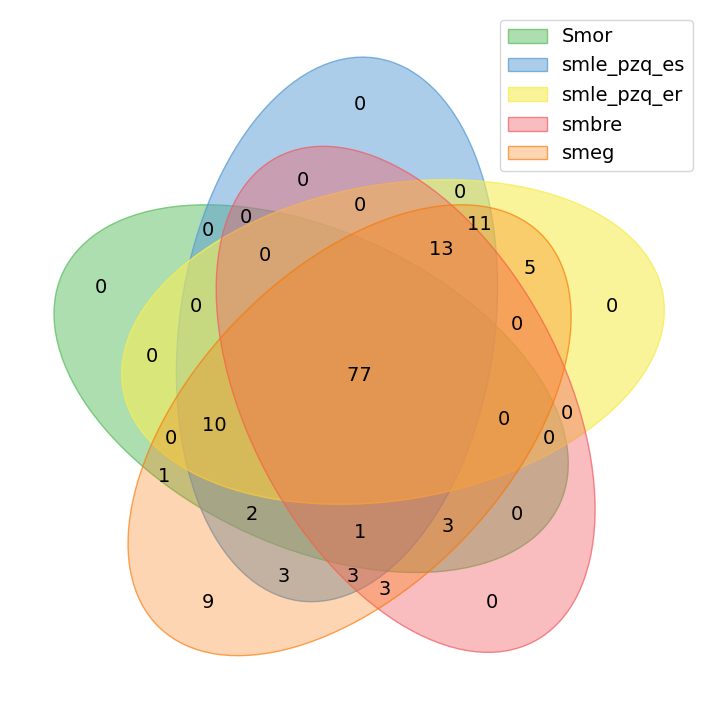

In [ ]:
labels = venn.get_labels([ genes["smor"], genes["smle_pzq_es"], genes["smle_pzq_er"], genes["smbre"], genes["smeg"]
                         ], fill=['number'])

fig, ax = venn.venn2(labels, names=['Smor', 'smle_pzq_es', 'smle_pzq_er', "smbre", "smeg"])
fig.show()
fig.savefig("gene_venn.png", dpi=600)

/master/nplatt/anaconda3/envs/sm_ont-svs/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  warn((


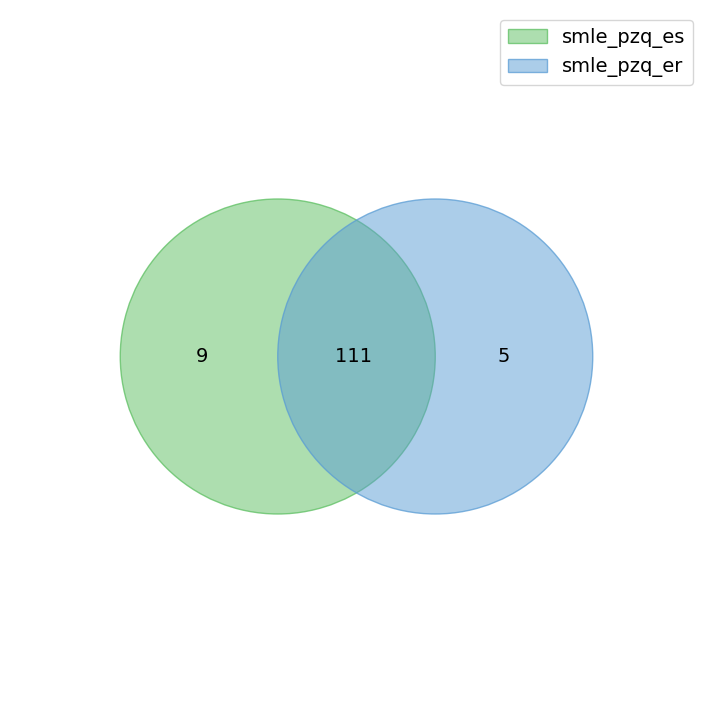

In [ ]:
labels = venn.get_labels([ genes["smle_pzq_es"], genes["smle_pzq_er"] ], fill=['number'])
fig, ax = venn.venn2(labels, names=['smle_pzq_es', 'smle_pzq_er'])
fig.show()
fig.savefig("gene_venn_smle.png", dpi=600)

## Number of SVs vs Coverage

In [ ]:
Path("{}/results/svs_vs_cov".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/svs_vs_cov".format(proj_dir))

In [ ]:
cov_thresh=8

filt_df=pd.read_csv(f"{proj_dir}/results/svs_and_genessv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv"/, sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,NaN
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,NaN
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,NaN
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,NaN
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,Smp_318880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,NaN
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,NaN
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,NaN
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,NaN


In [ ]:
covs_df=pd.read_csv(f"{proj_dir}/results/minimap2/covs.csv")
covs_df

,sample,length,bases,mean,min,max
0,smbre,391422299,12929852060,33.03,0,50203
1,smeg,391422299,8667206488,22.14,0,34244
2,smle_pzq_er,391422299,6624855708,16.93,0,10415
3,smle_pzq_es,391422299,21016896827,53.69,0,43483
4,smor,391422299,12178116550,31.11,0,79935


In [ ]:
covs={}
for index, row in covs_df.iterrows():
    covs[row["sample"]] = row["mean"]
    
covs

{'smbre': 33.03,
 'smeg': 22.14,
 'smle_pzq_er': 16.93,
 'smle_pzq_es': 53.69,
 'smor': 31.11}

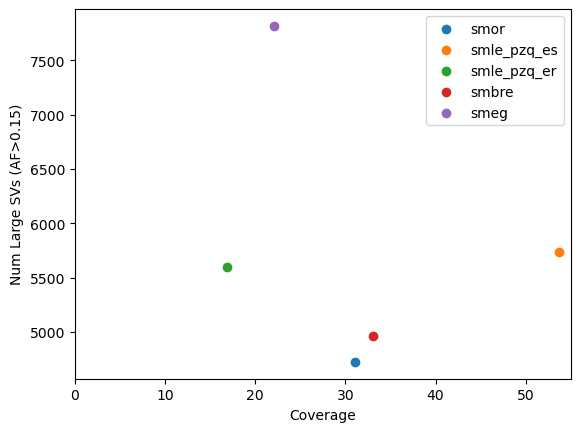

In [ ]:
for pop in pops:
    plt.scatter(covs[pop], sum(filt_df[f"{pop}.MAF"]>0.15), label=pop)
    
plt.ylabel("Num Large SVs (AF>0.15)")
plt.xlabel("Coverage")
plt.xlim([0,55])
plt.legend()
plt.savefig("num_svs_vs_cov.png", dpi=600)
plt.show()

## SV freq vs size

In [ ]:
Path("{}/results/sv_freq_vs_len".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/sv_freq_vs_len".format(proj_dir))

In [ ]:
cov_thresh=8

filt_df=pd.read_csv(f"{proj_dir}/results/svs_and_genes/sv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv", sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,NaN
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,NaN
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,NaN
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,NaN
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,Smp_318880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,NaN
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,NaN
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,NaN
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,NaN


In [ ]:
pop_labels={ "smor": "SmOR",
             "smbre": "SmBRE",
             "smeg": "SmEG",
             "smle_pzq_es": "SmLE_PZQ_ES",
             "smle_pzq_er": "SmLE_PZQ_ER" }

svtypes=list(filt_df["SVTYPE"].unique())

In [ ]:
filt_df.loc[ filt_df["SVTYPE"] == svtype ]

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
142,SM_V10_1,3073657,cuteSV.INV.0,A,['<INV>'],INV,1337.0,0.4400,0.4634,0.4167,0.9000,0.7368,25,41,24,20,19,NaN
143,SM_V10_1,3073716,cuteSV.INV.1,T,['<INV>'],INV,1296.0,0.4231,0.4524,0.4167,0.9000,0.7368,26,42,24,20,19,NaN
323,SM_V10_1,10311449,cuteSV.INV.2,C,['<INV>'],INV,417.0,0.3953,0.6230,0.5417,0.5957,0.3667,43,61,24,47,30,NaN
324,SM_V10_1,10311474,cuteSV.INV.3,G,['<INV>'],INV,380.0,0.3953,0.6230,0.5417,0.5957,0.3667,43,61,24,47,30,NaN
345,SM_V10_1,11887635,cuteSV.INV.4,T,['<INV>'],INV,3386.0,0.9048,0.4688,0.4444,0.0800,0.9048,21,32,9,25,21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7979,SM_V10_Z,82870095,cuteSV.INV.275,T,['<INV>'],INV,375.0,0.7619,0.8788,0.9000,0.9643,0.9167,21,33,10,28,24,NaN
7980,SM_V10_Z,82870096,cuteSV.INV.276,G,['<INV>'],INV,365.0,0.7619,0.8788,0.9000,0.9643,0.9167,21,33,10,28,24,NaN
7990,SM_V10_Z,83447374,cuteSV.INV.277,T,['<INV>'],INV,1418.0,0.6471,0.7778,0.1818,0.8182,0.3125,17,18,11,11,16,NaN
8072,SM_V10_Z,85507324,cuteSV.INV.278,A,['<INV>'],INV,2548.0,0.5882,0.0541,0.1538,0.0000,0.3125,17,37,13,19,16,NaN


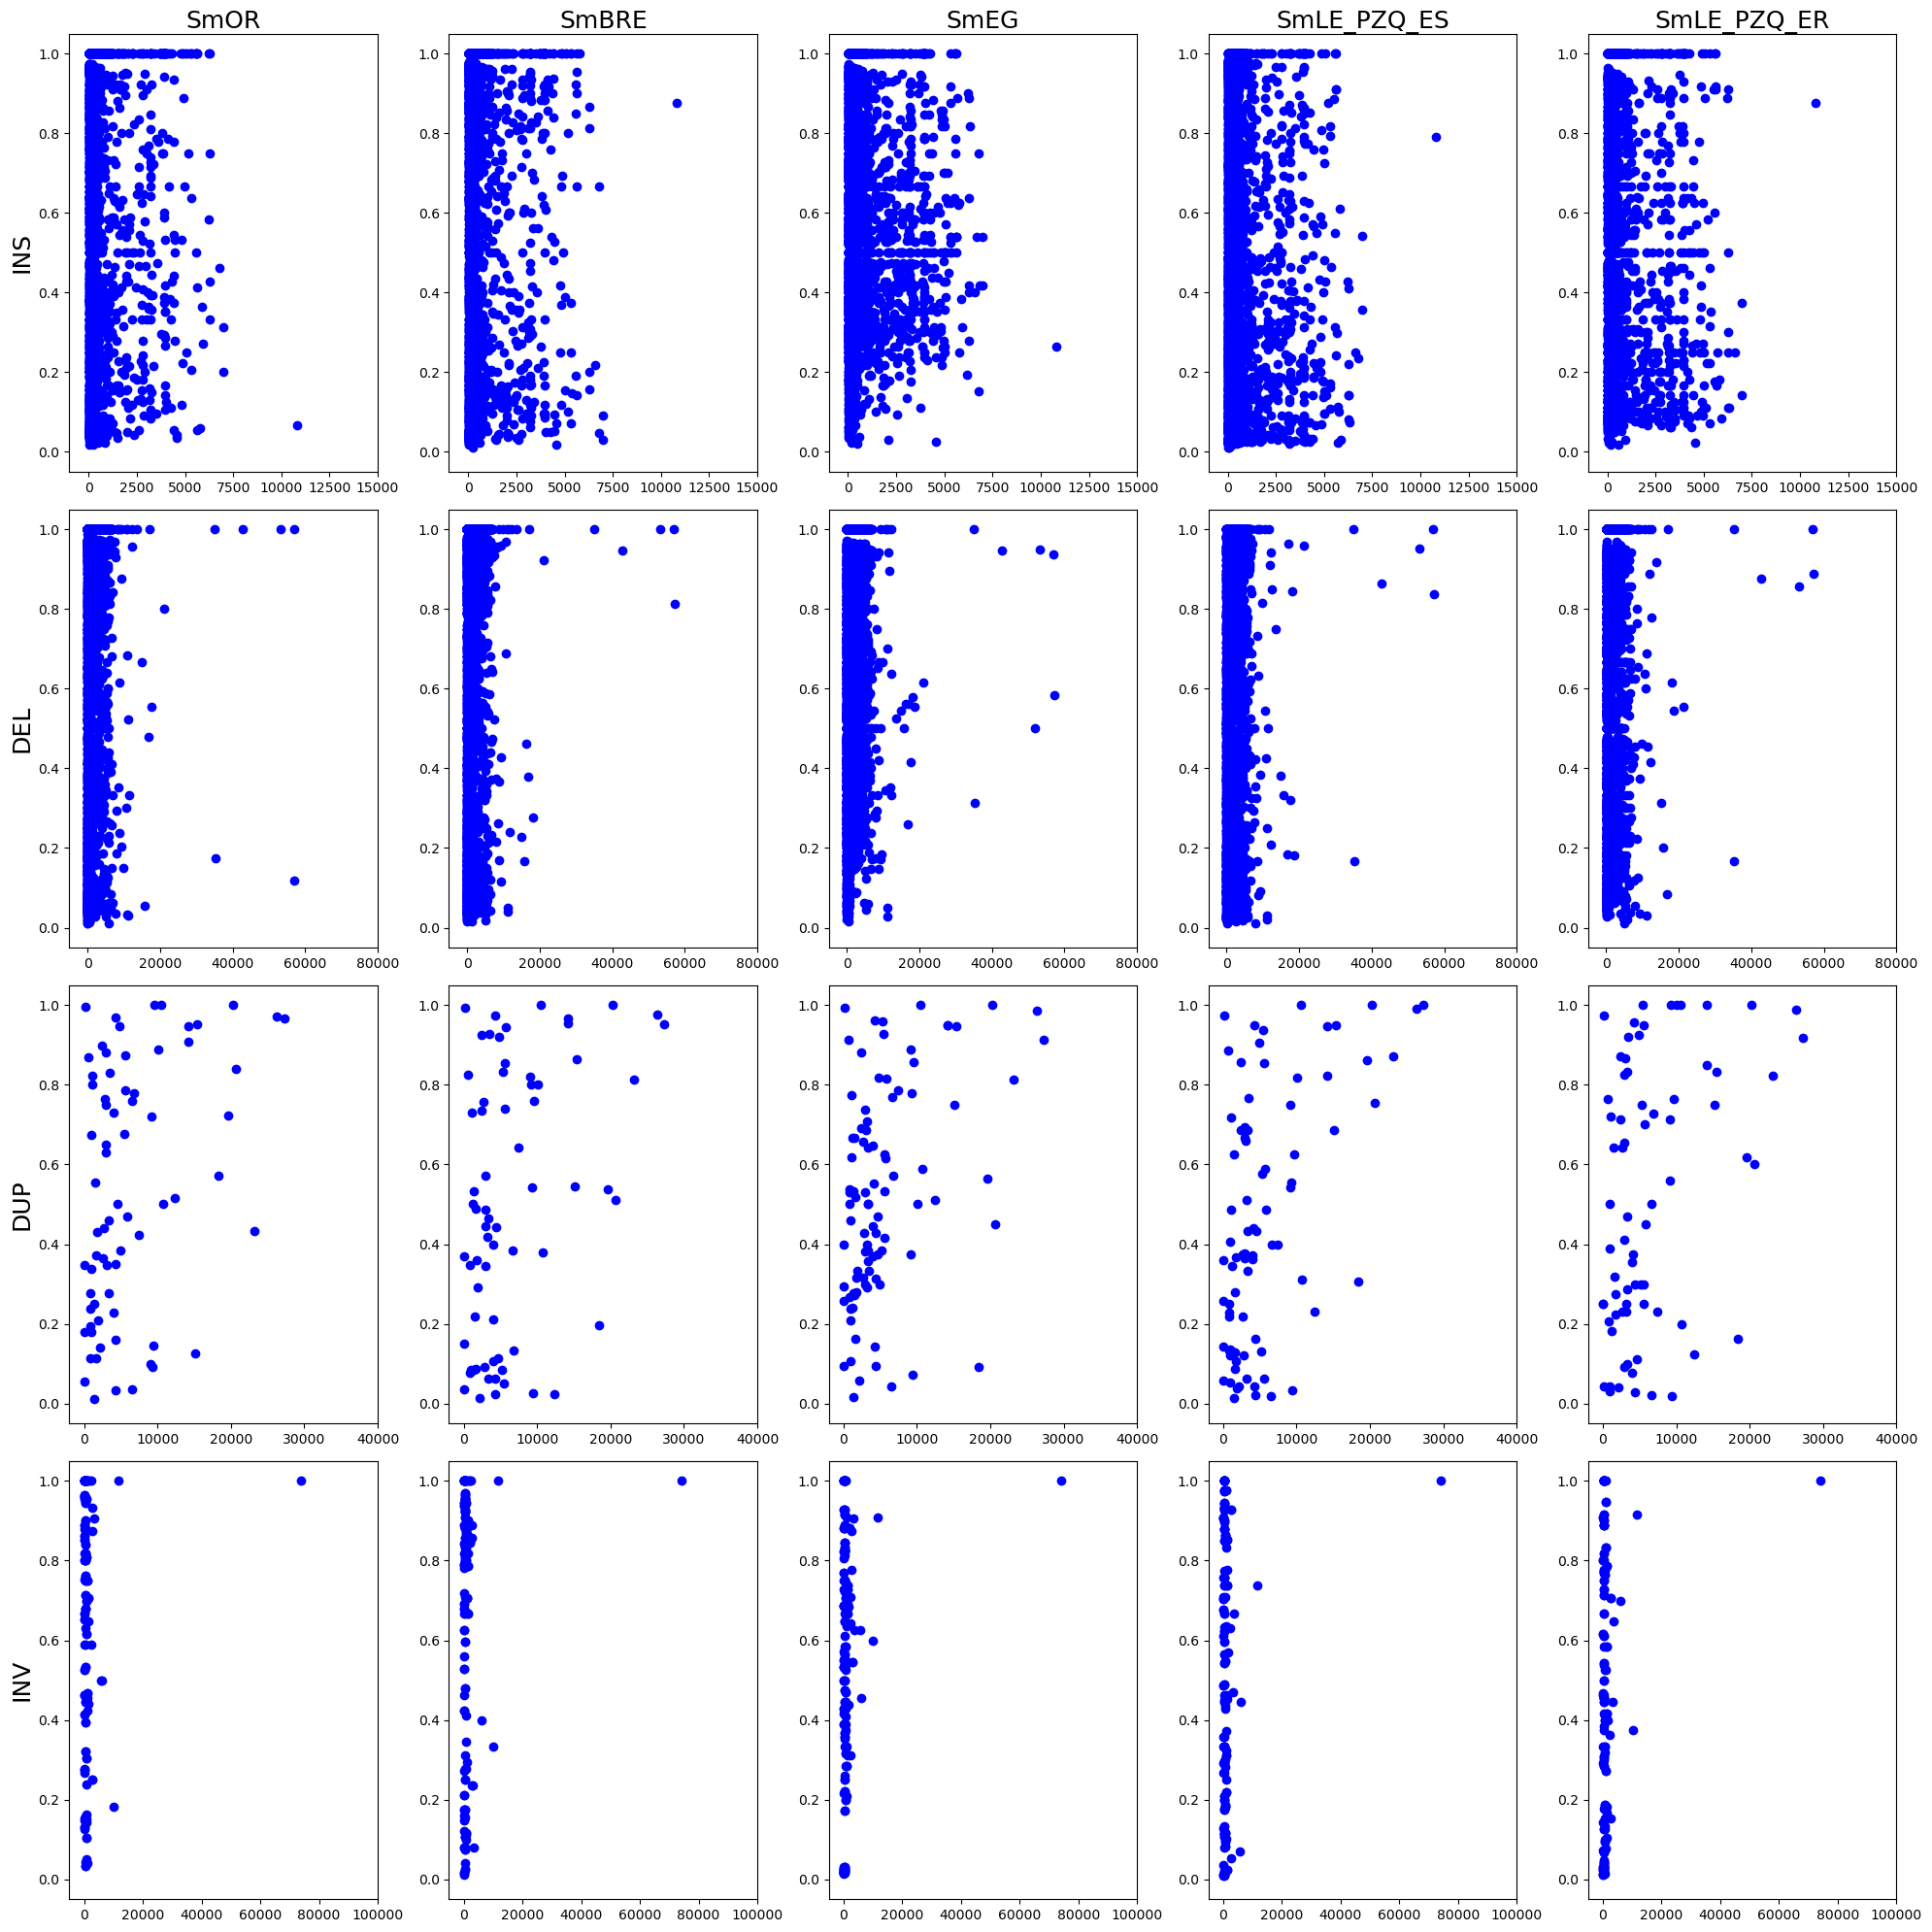

In [ ]:
# Assuming colors is a dictionary mapping SVTYPE to a specific color
# And dfs is a dictionary mapping population names to their respective dataframes

# List of populations
populations = list(pop_labels
# Define x-axis limits for each SVTYPE
x_limits = {
    "DUP": (-2_000, 40_000),
    "INV": (-5_000, 100_000),
    "DEL": (-5_000, 80_000),
    "INS": (-1_000, 15_000)
}

# Loop over each SVTYPE and each population
for i, svtype in enumerate(svtypes):
    for j, pop in enumerate(populations):
        subset = filt_df.loc[ (filt_df["SVTYPE"] == svtype) & (filt_df[f"{pop}.MAF"] > 0.01) ]
        
        # Plot on the specific axis
        ax = axes[i, j]
        ax.scatter(abs(subset["SVLEN"].astype(int)), subset[f"{pop}.MAF"blue")
        
        # Set y-axis limits
        ax.set_ylim(-0.05, 1.05)
        
        # Set x-axis limits based on the SVTYPE
        if svtype in x_limits:
            ax.set_xlim(x_limits[svtype])
        
# Adjust plot titles, y-labels, and x-labels
for i in range(len(svtypes)):
    axes[i, 0].set_ylabel(svtypes[i], fontsize=18)

for j in range(len(populations)):
    axes[0, j].set_xlabel(pop_labels[populations[j]], fontsize=18)
    axes[0, j].xaxis.set_label_position('top')  # Move the x-labels to the top for clarity

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig("freq_vs_len_by_pop_by_type.png", dpi=300)
plt.savefig("freq_vs_len_by_pop_by_type.svg")
plt.show()
].astype(float), color=".keys())

# List of SVTYPEs
#svtypes = list(colors.keys())

# Create a grid of subplots, number of rows = number of SVTYPEs, number of columns = number of populations
fig, axes = plt.subplots(len(svtypes), len(populations), figsize=(20, 5 * len(svtypes)))


## fst

In [958]:
Path("{}/results/fst".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/fst".format(proj_dir))

In [959]:
cov_thresh=8

filt_df=pd.read_csv(f"{proj_dir}/results/svs_and_genes/sv_cat_afs_dp_ge_{cov_thresh}_w_genes.csv", sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,NaN
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,NaN
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,NaN
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,NaN
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,Smp_318880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,NaN
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,NaN
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,NaN
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,NaN


In [764]:
#use grenedalf to calculate per site fst from freq table

In [962]:
#prep for grenedalf with coverages
g_df=filt_df.copy()

g_df["ALT"] = g_df["ALT"].str.replace("^\['", "", regex=True)
g_df["ALT"] = g_df["ALT"].str.replace("\']$", "", regex=True)
g_df.to_csv("to_grenedalf.csv", sep=",", header=True, index=False)
g_df
 
    

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV,gene_ids
0,SM_V10_1,108036,cuteSV.INS.4,C,CATTATTATTATTATTATTACTACTATTATTATTACTATT,INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23,NaN
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,A,DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25,NaN
2,SM_V10_1,214273,cuteSV.INS.8,T,TGATGATGATGATAGATATTGATGATGATGATGATGATGATGATGA...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16,NaN
3,SM_V10_1,258698,cuteSV.INS.9,A,ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTTTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16,NaN
4,SM_V10_1,264300,cuteSV.INS.10,C,CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCTCA...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46,Smp_318880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTATT...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16,NaN
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACAGA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20,NaN
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,G,DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54,NaN
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGAAG...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40,NaN


## how much of the genome is in large SVs.

In [18]:
Path("{}/results/mbs_in_svs".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/mbs_in_svs".format(proj_dir))

In [21]:
cov_thresh=1

filt_df=pd.read_csv(f"{proj_dir}/results/collapse_svs/sv_cat_afs_dp_ge_{cov_thresh}.csv", sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV
0,SM_V10_1,75869,cuteSV.INS.3,A,['ACCGAGTTTAGGTTGGACATTGTGAATCACTGCACGTATAATCC...,INS,4434.0,1.0000,0.7500,1.0000,0.7000,1.0000,5,12,3,10,7
1,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23
2,SM_V10_1,133233,cuteSV.INS.5,T,['TATCATCATCATCATCATCATCATCATCATCATCATCATCATCA...,INS,77.0,0.6667,0.1346,0.0000,0.0000,0.3333,6,52,9,1,15
3,SM_V10_1,147575,cuteSV.INS.6,T,['TCATCATCATCATCATCATCATCATCATCATCATCATCATCGTA...,INS,64.0,0.0588,0.2857,0.0000,0.5000,0.0833,17,77,9,2,24
4,SM_V10_1,147670,cuteSV.DEL.6,ATCATCATCATCATCATCATCATCATCATCATCATCATCATCATCA...,['A'],DEL,-70.0,0.0000,0.0448,0.0000,0.0000,0.2500,17,67,9,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9819,SM_V10_Z,86617090,cuteSV.DEL.5156,ATTCAAACACTTCACTTCCACCCGAACTTTGTGCTGATGATGTCGT...,['A'],DEL,-131.0,0.0000,0.1333,0.0000,0.1395,0.3000,40,45,3,43,20
9820,SM_V10_Z,86617306,cuteSV.DEL.5157,CAGTGAATAAAAACTAGTGACATTAACGTAATATCTGTGTGAAATT...,['C'],DEL,-1136.0,0.0000,0.0930,0.0000,0.1190,0.2500,40,43,3,42,20
9821,SM_V10_Z,86621985,cuteSV.DEL.5158,TTATACATGGTAGAATTATCCGTTTGACGTTTTCCGTACGTGACTT...,['T'],DEL,-154.0,0.0000,0.1852,0.0000,0.1429,0.5000,19,27,2,35,14
9822,SM_V10_Z,86626771,cuteSV.DEL.5159,AGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAGTAAG...,['A'],DEL,-358.0,0.7727,0.4500,0.0000,0.1538,0.4167,22,20,1,26,12


In [25]:
len_df=pd.read_csv(f"{proj_dir}/data/genome/SM_V10.fa.fai", sep="\t", header=None)
len_df.columns=["name", "length", "offset", "linebases", "linewidth"]
genome_bp = len_df["length"].sum()

In [22]:
sv_bp=sum([abs(x) for x in filt_df["SVLEN"]])
sv_bp

11440195.0

In [26]:
sv_bp/genome_bp

0.029227243898028405

## What is the breakdown of types of SVs

In [42]:
Path("{}/results/sv_type_counts_piechart".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/sv_type_counts_piechart".format(proj_dir))

In [43]:
cov_thresh=8

filt_df=pd.read_csv(f"{proj_dir}/results/collapse_svs/sv_cat_afs_dp_ge_{cov_thresh}.csv", sep=",", header=0)
filt_df

,CHROM,POS,ID,REF,ALT,SVTYPE,SVLEN,smor.MAF,smle_pzq_es.MAF,smle_pzq_er.MAF,smbre.MAF,smeg.MAF,smor.COV,smle_pzq_es.COV,smle_pzq_er.COV,smbre.COV,smeg.COV
0,SM_V10_1,108036,cuteSV.INS.4,C,['CATTATTATTATTATTATTACTACTATTATTATTACTATT'],INS,39.0,1.0000,0.9429,0.8889,1.0000,0.9565,25,70,18,25,23
1,SM_V10_1,156118,cuteSV.DEL.7,ATGTTATCTTTGGCAGCCTATTTAAACATCTGGGCTACCTGTTCCT...,['A'],DEL,-401.0,0.3500,0.1587,0.3846,0.8750,0.2800,20,63,13,8,25
2,SM_V10_1,214273,cuteSV.INS.8,T,['TGATGATGATGATAGATATTGATGATGATGATGATGATGATGAT...,INS,51.0,0.1304,0.6667,0.9333,0.8696,0.3125,23,36,15,23,16
3,SM_V10_1,258698,cuteSV.INS.9,A,['ACTCGGGAATAACATTAGGATCACTTCAATTTTTTTAATAATTT...,INS,4470.0,0.2778,0.1897,0.1429,0.0930,0.3125,18,58,14,43,16
4,SM_V10_1,264300,cuteSV.INS.10,C,['CCTGGAAGCACTGGACGGCCGTTTCGTCCTATTGGCGGACCCCT...,INS,324.0,0.6579,0.2637,0.5455,0.6269,0.1522,38,91,22,67,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,SM_V10_Z,86357919,cuteSV.INS.4444,T,['TTGTTATGTCCCCTGGTGAATTATAAATGGTAACTCTGAGTCTA...,INS,604.0,0.3333,0.2222,0.1250,0.9545,0.3750,18,36,16,22,16
8097,SM_V10_Z,86361688,cuteSV.INS.4445,A,['AATCAGTAAGCGAGTAGTGATGGAAGTTTGGTTATTTTGGTACA...,INS,325.0,1.0000,1.0000,1.0000,1.0000,1.0000,17,47,26,24,20
8098,SM_V10_Z,86465601,cuteSV.DEL.5146,GTGCGCGTTCAAAAAGCGGATCACAAACTTTGTAGAAAAAT,['G'],DEL,-40.0,0.5000,0.2022,0.2292,0.0000,0.1667,38,89,48,29,54
8099,SM_V10_Z,86467302,cuteSV.INS.4446,G,['GAATTCTATATTTTTCAAGGGAGTTGAAATCATAAGTCAATCGA...,INS,229.0,0.5238,0.1860,0.0263,1.0000,0.1500,21,86,38,35,40


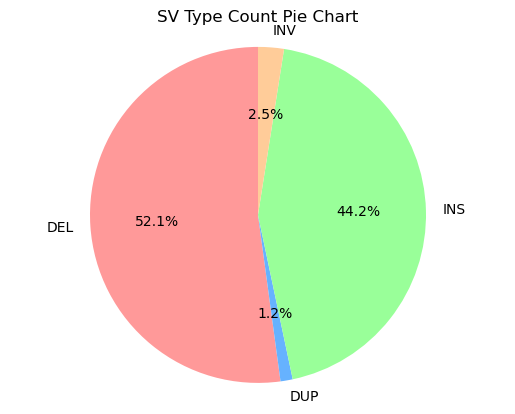

In [44]:
# sv_type_count = filt_df.loc[abs(filt_df["SVLEN"]) > 500].groupby("SVTYPE")["SVTYPE"].count().to_dict()

sv_type_count = filt_df.groupby("SVTYPE")["SVTYPE"].count().to_dict()

# Data for the pie chart
labels = list(sv_type_count.keys())
sizes = list(sv_type_count.values())
colors = ['#ff9999', '#66b2ff', '#99ff99', '#ffcc99']

# Plotting the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title("SV Type Count Pie Chart")
plt.savefig("svtype_count_piechart.png", dpi=300)
plt.savefig("svtype_count_piechart.svg")
plt.show()